# Model comparisons
This notebook includes code for comparing LSTM, ParFlow-CLM, and UA SWE model performance on a representative set of national test sites. The first section of the code generates performance statistics for individual models. The section section of the code generates plots to compare model performance across all national test sites, in specific regions, and on individual years from the testing dataset. 

In [1]:
# preliminaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import stats
import netCDF4
import xarray as xr
import seaborn as sns
import pickle
import torch
from statsmodels.distributions.empirical_distribution import ECDF
from mpl_toolkits.basemap import Basemap
from collections import defaultdict
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch

from _data import *
from _lstm import *

# sns set1 palette: LSTM: '#e41a1c', SNOTEL: '#377eb8', PFCLM:'#4daf4a', UA SWE:'#984ea3'

In [4]:
hf.get_citations('CW3E')

'Meteorological Forcing Data for Conus2 Grid\n  Source: https://cw3e.ucsd.edu\n'

# Get data for individual models

## UA SWE data

In [2]:
# LAT AND LON VALUES
model = xr.open_dataset('Data/UA_SWE/4km_SWE_Depth_WY2000_v01.nc')
lat_values = model['lat'].values
lon_values = model['lon'].values

In [3]:
# GET TESTING DATA 
test_sites = pd.read_csv('national_test_sites.txt', sep=' ',header=None)
test_sites.columns = ['site_id', 'site_name', 'site_type', 'agency', 'state','first_date_data_available', 'last_date_data_available', 'record_count',
                     'latitude', 'longitude', 'bins','first_wy_date', 'last_wy_date']

test_years = pd.read_csv('national_test_years.txt', sep=' ',header=None)
test_years.columns = ['site_id', 'year', 'train']

base_pfclm = '/home/mcburns/pfclm/output/'

/tmp/ipykernel_3411949/4135509914.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_statistics = pd.concat([total_statistics, single_statistics], ignore_index=True)


RMSE: 88.99
normal RMSE: 0.22
NSE: 0.41
R2: 0.41
Spearman's rho: 0.90
delta peak SWE: -65.89
normal delta peak SWE: -0.18
absolute delta peak SWE: 150.17
absolute normal delta peak SWE: 0.39
delta days: -6.93
absolute delta days: 20.63


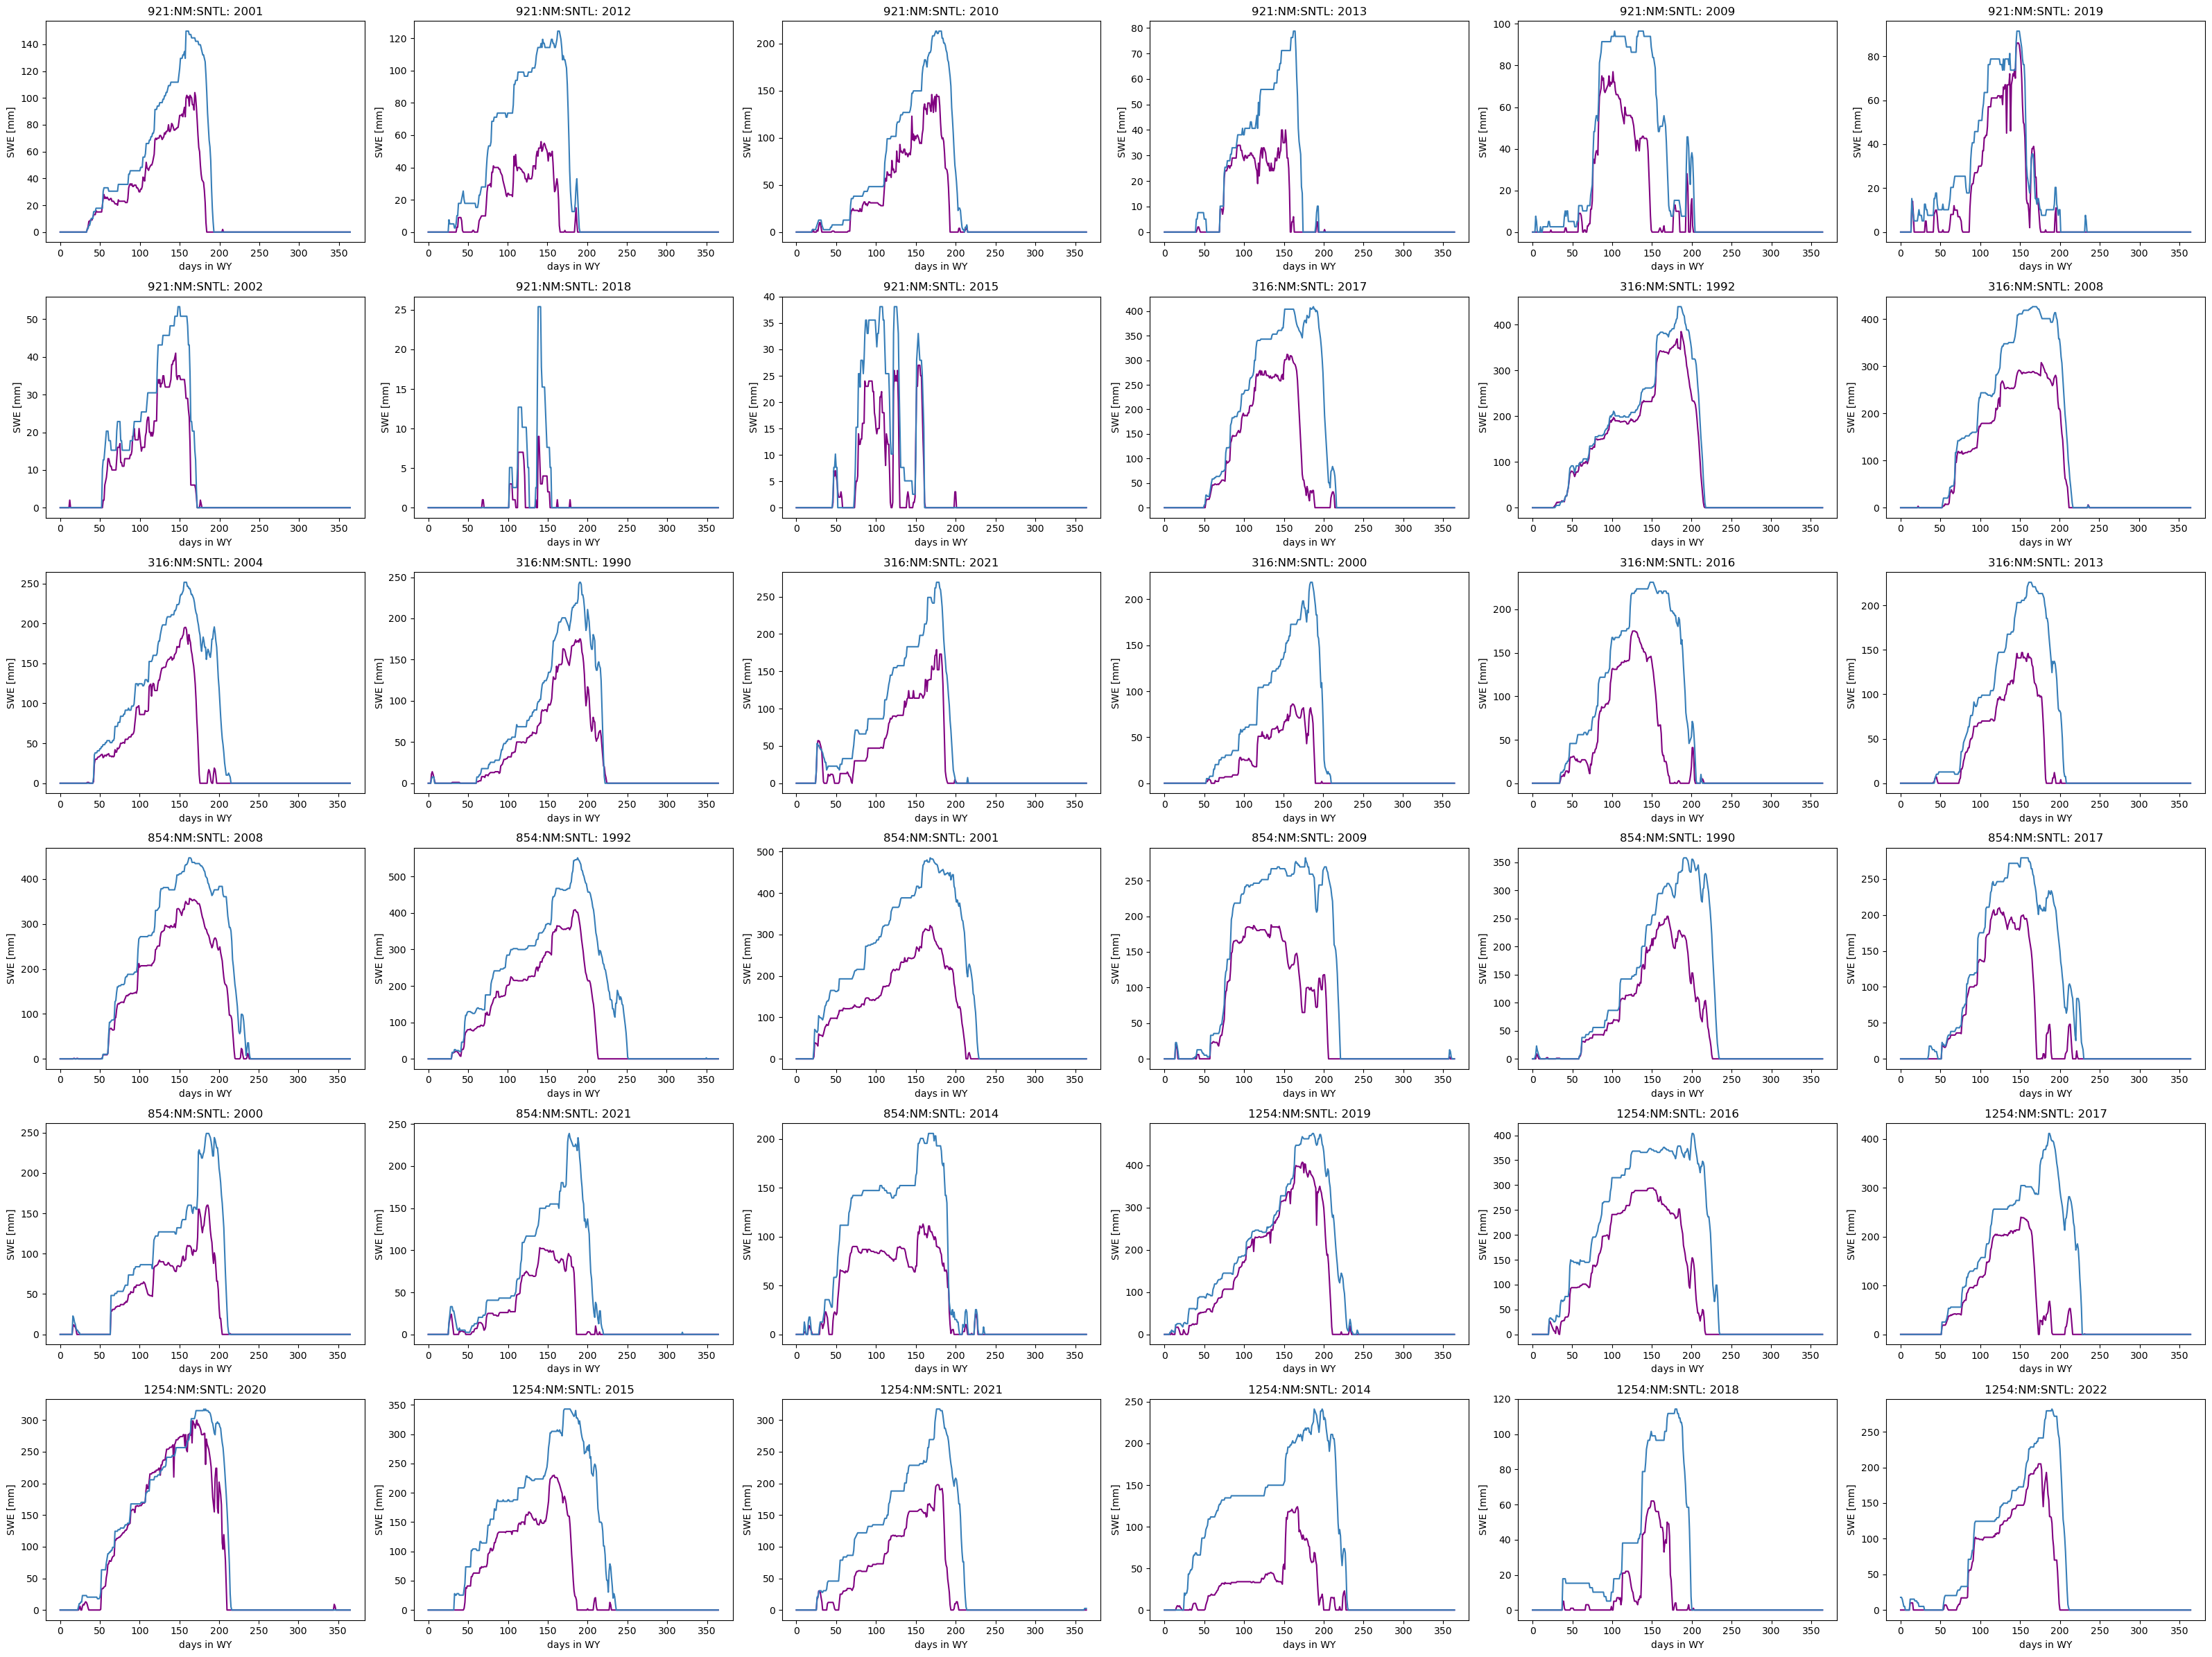

In [7]:
# ANALYZE MODEL OUTPUT
plt.figure(figsize=(32,24))

total_statistics = pd.DataFrame(columns=['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak','normal delta peak', 'abs delta peak', 
                                         'normal abs delta peak','delta days', 'abs delta days'])

for i in range(len(test_sites)):
    # get data about each site
    lat = test_sites['latitude'][i]
    lon = test_sites['longitude'][i]
    site_id = test_sites['site_id'][i]

    # transform lat & lon coordinates
    # assumes that the coordinate is the bottom right corner of the box
    # assumes that there is no coordinates higher than 49.92
    for j in np.arange(1, len(lat_values)):
        l_current = lat_values[j]
        if (lat <= l_current): #and (lat > l_last):
            lat_coord = lat_values[j-1]      #i-1
            break
    for j in np.arange(1, len(lon_values)):
        l_last = lon_values[j-1]
        l_current = lon_values[j]
        if (lat >= l_last) and (lon < l_current):
            lon_coord = lon_values[j-1]
            break

    # get data & model predictions for each year
    years = test_years[test_years['site_id'] == site_id].reset_index().drop(columns=['index'])
    if len(years) == 0:
        print(site_id)
    for j in range(len(years)):
        year = years['year'][j]
        model = xr.open_dataset('Data/UA_SWE/4km_SWE_Depth_WY'+str(year)+'_v01.nc')
        swe_ua = model.sel(lat=lat_coord, lon=lon_coord)['SWE'].values

        # read actual SWE
        swe_actual = pd.read_csv(os.path.join('Data/PFCLM_output/' + site_id+'/'+str(year), site_id+'_'+str(year)+'_swe.txt'), 
                                 sep=' ',header=None,index_col=False)
        swe_actual.columns = ['date', 'swe']
        swe_actual['swe'] =  swe_actual['swe'].interpolate(method='linear', limit_direction='both')

        # drop leap day
        # if len(swe_actual) == 366:
        #     swe_actual = swe_actual.drop(60).reset_index()
        #     swe_ua = swe_ua.drop(60).reset_index()

        # analyze statistics
        single_statistics = analyze_results_pfclm(swe_ua, swe_actual['swe'], site_id, year)

        total_statistics = pd.concat([total_statistics, single_statistics], ignore_index=True)

        if (int(i*len(years)+j) < 36):
            plt.subplot(6, 6, int(i*len(years)+j)+1)
            # blue is actual, purple is predicted
            plt.plot(swe_ua, label='UA predicted swe', c='purple')
            plt.plot(swe_actual['swe'], label='actual swe', c='#377eb8')
            plt.title(site_id + ': '+ str(year))
            plt.xlabel('days in WY')
            plt.ylabel('SWE [mm]')
    
    plt.tight_layout()

In [4]:
# SAVE STATISTICS
#total_statistics.to_csv('/home/mcburns/UA_SWE_data/national_statistics.txt',sep=' ',header=None, index=False, index_label=False)
total_statistics = pd.read_csv('Data/UA_SWE/national_statistics.txt',sep=' ',header=None)
total_statistics.columns = ['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak','normal delta peak', 'abs delta peak', 
                            'normal abs delta peak','delta days', 'abs delta days']

## PRINT STATISTICS ##
# drop years 666 and 65 because of erroneous/missing meteorologial data
print('\nMeans:')
print(f"RMSE: {np.mean(total_statistics.drop([666, 65])['rmse']):.2f}")
print(f"normal RMSE: {np.mean(total_statistics.drop([666, 65])['normal rmse']):.2f}")
print(f"NSE: {np.mean(total_statistics.drop([666, 65])['nse']):.2f}")
print(f"R2: {np.mean(total_statistics.drop([666, 65])['r2']):.2f}")
print(f"Spearman's rho: {np.mean(total_statistics.drop([666, 65])['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.mean(total_statistics.drop([666, 65])['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(total_statistics.drop([666, 65])['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.mean(total_statistics.drop([666, 65])['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.mean(total_statistics.drop([666, 65])['normal abs delta peak']):.2f}")
print(f"delta days: {np.mean(total_statistics.drop([666, 65])['delta days']):.2f}")
print(f"absolute delta days: {np.mean(total_statistics.drop([666, 65])['abs delta days']):.2f}")

print('Medians:')
print(f"RMSE: {np.median(total_statistics.drop([666, 65])['rmse']):.2f}")
print(f"normal RMSE: {np.median(total_statistics.drop([666, 65])['normal rmse']):.2f}")
print(f"NSE: {np.median(total_statistics.drop([666, 65])['nse']):.2f}")
print(f"R2: {np.median(total_statistics.drop([666, 65])['r2']):.2f}")
print(f"Spearman's rho: {np.median(total_statistics.drop([666, 65])['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.median(total_statistics.drop([666, 65])['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.median(total_statistics.drop([666, 65])['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.median(total_statistics.drop([666, 65])['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.median(total_statistics.drop([666, 65])['normal abs delta peak']):.2f}")
print(f"delta days: {np.median(total_statistics.drop([666, 65])['delta days']):.2f}")
print(f"absolute delta days: {np.median(total_statistics.drop([666, 65])['abs delta days']):.2f}")

print('\nStandard deviations:')
print(f"RMSE: {np.std(total_statistics.drop([666, 65])['rmse']):.2f}")
print(f"normal RMSE: {np.std(total_statistics.drop([666, 65])['normal rmse']):.2f}")
print(f"NSE: {np.std(total_statistics.drop([666, 65])['nse']):.2f}")
print(f"delta peak SWE: {np.std(total_statistics.drop([666, 65])['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.std(total_statistics.drop([666, 65])['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.std(total_statistics.drop([666, 65])['abs delta peak']):.2f}")
print(f"normal absolute delta peak SWE: {np.std(total_statistics.drop([666, 65])['normal abs delta peak']):.2f}")
print(f"delta days: {np.std(total_statistics.drop([666, 65])['delta days']):.2f}")
print(f"absolute delta days: {np.std(total_statistics.drop([666, 65])['abs delta days']):.2f}")


Means:
RMSE: 88.72
normal RMSE: 0.22
NSE: 0.41
R2: 0.41
Spearman's rho: 0.90
delta peak SWE: -65.27
normal delta peak SWE: -0.18
absolute delta peak SWE: 149.74
absolute normal delta peak SWE: 0.39
delta days: -6.92
absolute delta days: 20.65
Medians:
RMSE: 60.60
normal RMSE: 0.17
NSE: 0.75
R2: 0.75
Spearman's rho: 0.94
delta peak SWE: -46.25
normal delta peak SWE: -0.13
absolute delta peak SWE: 99.14
absolute normal delta peak SWE: 0.29
delta days: -3.00
absolute delta days: 14.00

Standard deviations:
RMSE: 91.08
normal RMSE: 0.17
NSE: 1.13
delta peak SWE: 216.63
normal delta peak SWE: 0.49
absolute delta peak SWE: 169.61
normal absolute delta peak SWE: 0.36
delta days: 30.83
absolute delta days: 23.92


## ParFlow-CLM

/tmp/ipykernel_2451657/3485319633.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_statistics_pf = pd.concat([total_statistics_pf, single_statistics], ignore_index=True)


RMSE: 110.83
normal RMSE: 0.26
NSE: -1.02
R2: -1.02
Spearman's rho: 0.87
delta peak SWE: -90.50
normal delta peak SWE: -0.32
absolute delta peak SWE: 157.57
absolute normal delta peak SWE: 0.41
delta days: 1.09
absolute delta days: 24.20


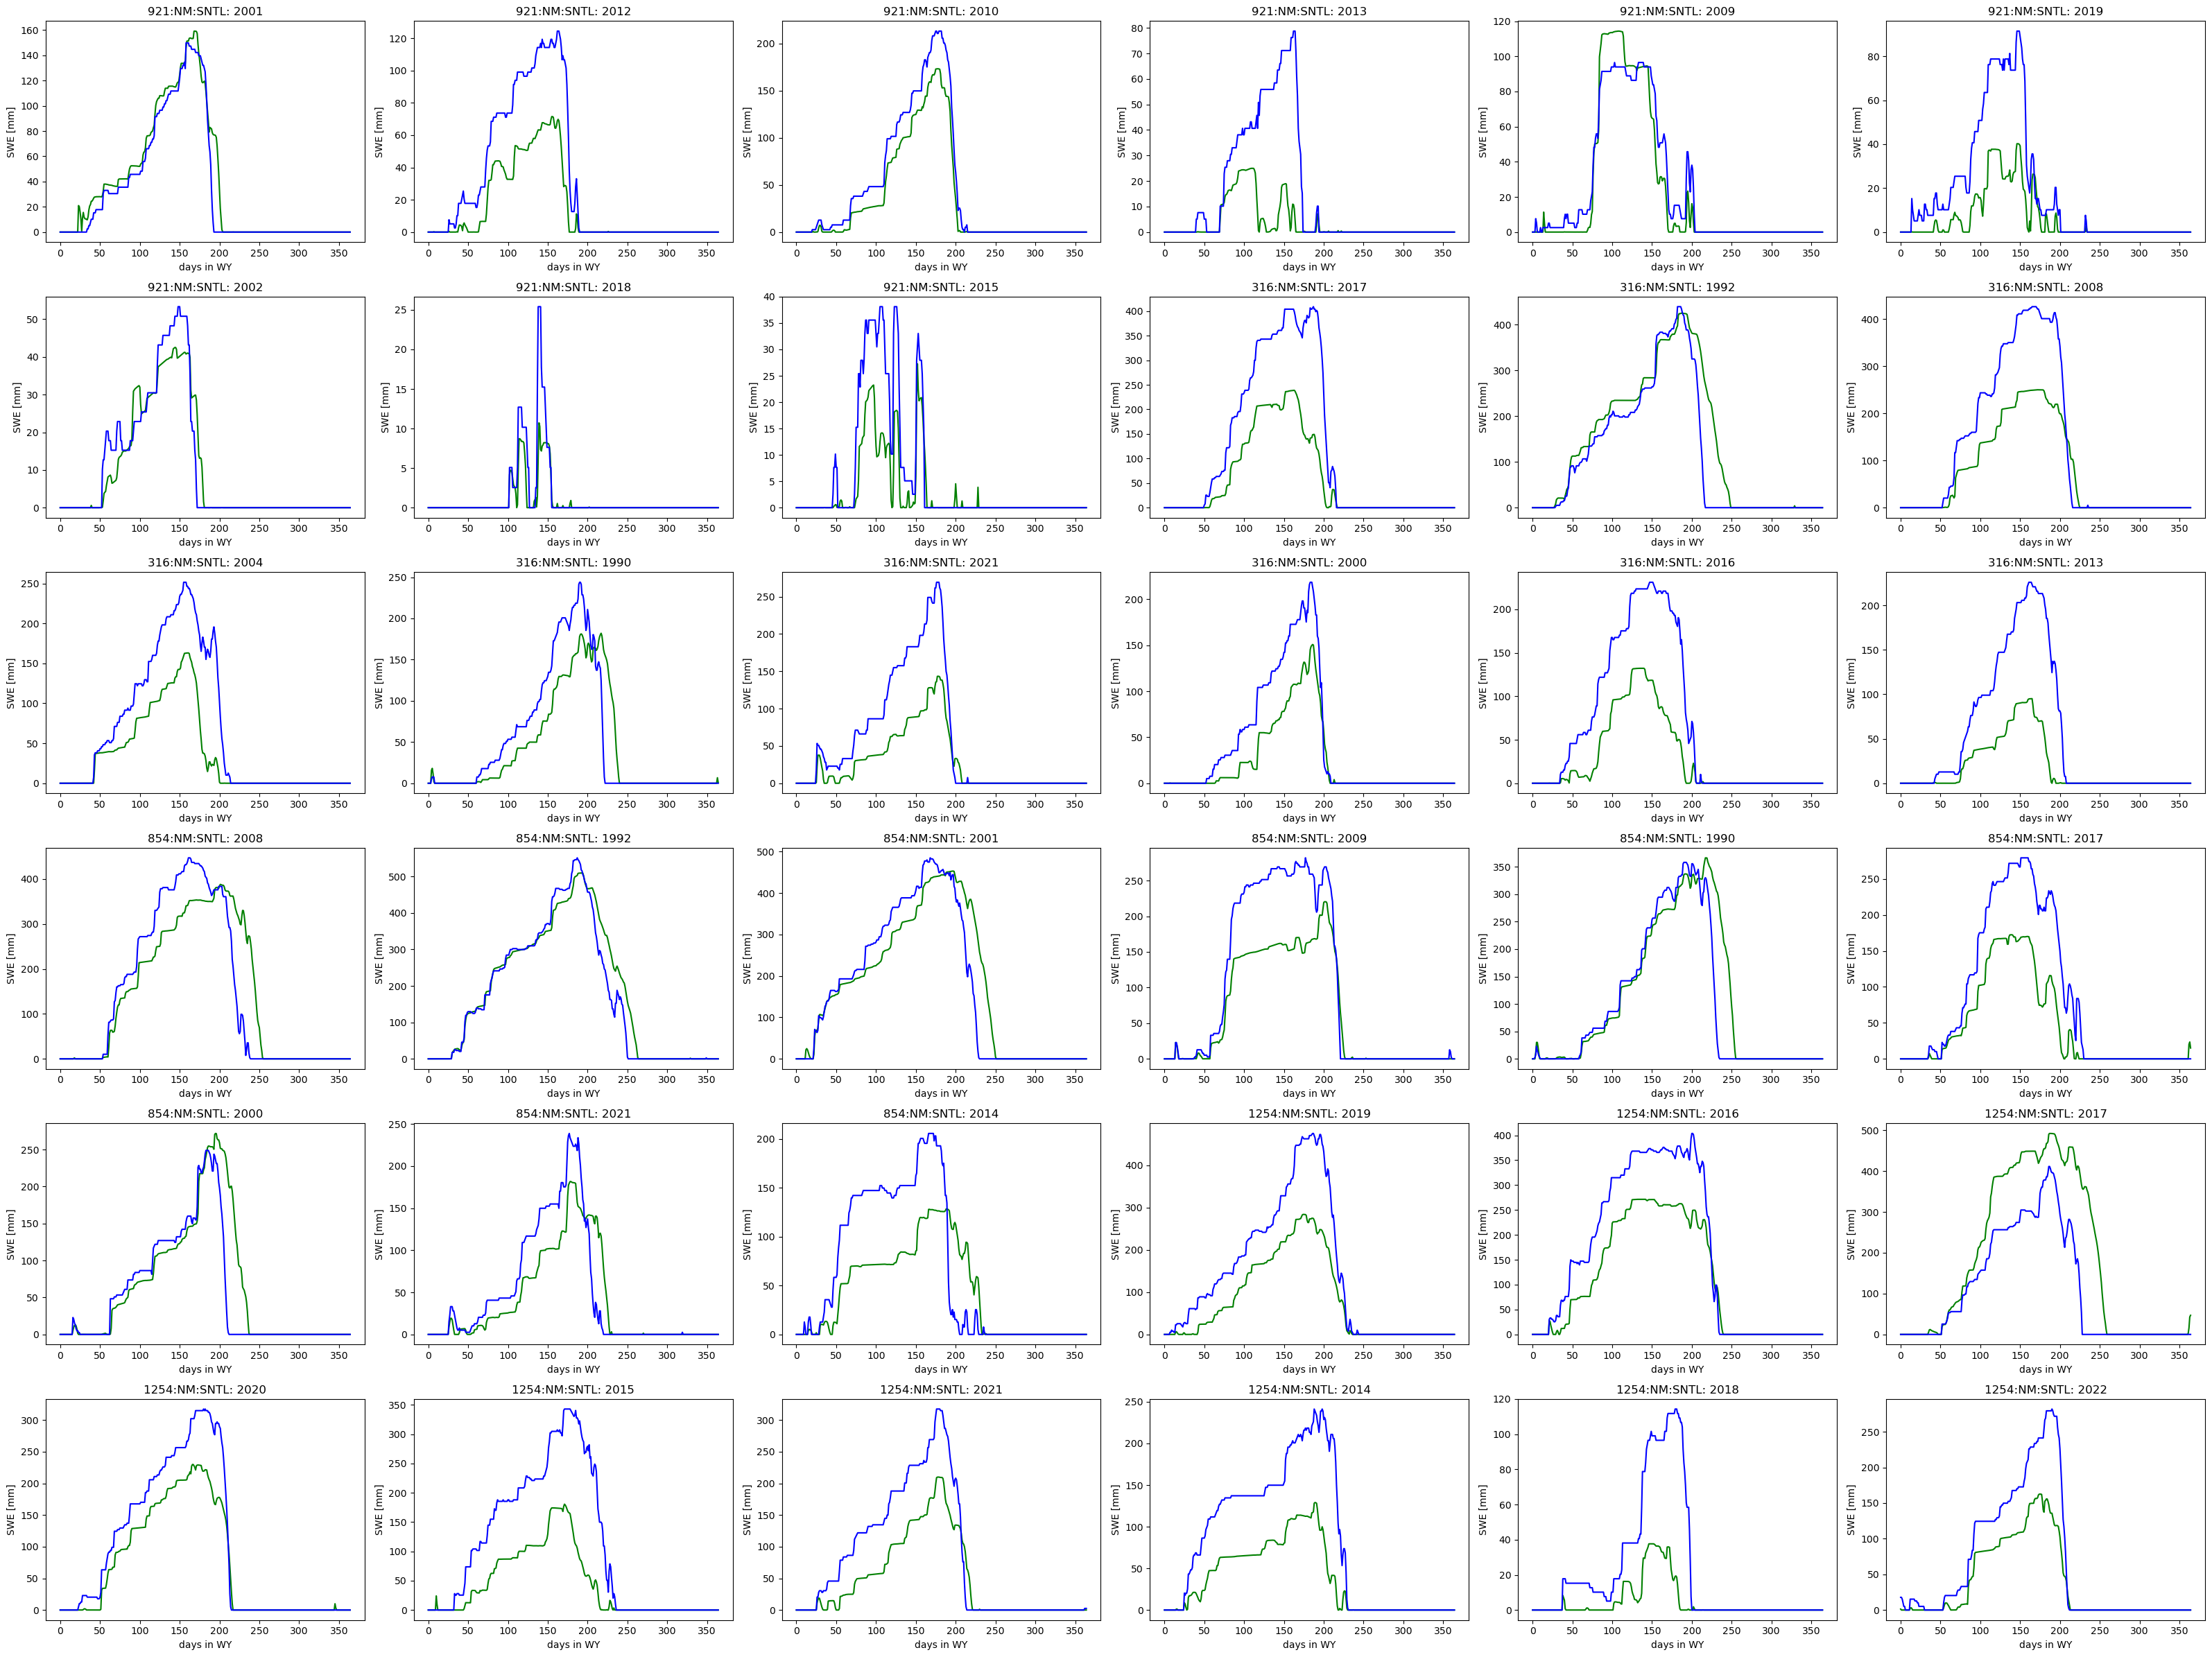

In [5]:
# GET TESTING DATA
data_test = pd.read_csv('national_test_years.txt', sep=' ',header=None)
data_test.columns = ['site_id',	'year',	'train']

plt.figure(figsize=(32,24))
#plt.figure(figsize=(16,10))

total_statistics_pf = pd.DataFrame(columns=['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'abs delta peak',
                                            'normal abs delta peak','delta days','abs delta days'])

# GET PARFLOW RESULTS FOR EACH SITE
for j in range(0, len(data_test)):
    site_id = data_test['site_id'][j]
    year = data_test['year'][j]
    start_date = str(year-1) + '-10-01'
    end_date = str(year) + '-09-30'

    try:
        swe_clm, swe_actual = prod_swe(site_id, year)
        
        single_statistics = analyze_results_pfclm(swe_clm['swe'], swe_actual['swe'], site_id, year)
    
        total_statistics_pf = pd.concat([total_statistics_pf, single_statistics], ignore_index=True)
        
        # for regional/national model:
        if (j < 36):
            plt.subplot(6, 6, j+1)
            # blue is actual, green is predicted
            plt.plot(swe_clm, label='predicted swe', c='green')
            plt.plot(swe_actual['swe'], label='actual swe', c='#377eb8')
            plt.title(site_id + ': '+ str(year))
            plt.xlabel('days in WY')
            plt.ylabel('SWE [mm]')
    except:
        print('PFCLM run error in location ',j, ' at ', site_id, year)


plt.tight_layout()

In [5]:
#total_statistics_pf.to_csv('/home/mcburns/pfclm/national_statistics.txt',sep=' ',header=None, index=False, index_label=False)
total_statistics_pf = pd.read_csv('Data/PFCLM_output/national_statistics.txt',sep=' ',header=None)
total_statistics_pf.columns = ['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'abs delta peak', 
                               'normal abs delta peak', 'delta days', 'abs delta days']

## PRINT STATISTICS ##
# drop years 666 and 65 because of erroneous/missing meteorologial data
# means
print('Means')
print(f"RMSE: {np.mean(total_statistics_pf.drop([666, 65])['rmse']):.2f}")
print(f"normal RMSE: {np.mean(total_statistics_pf.drop([666, 65])['normal rmse']):.2f}")
print(f"NSE: {np.mean(total_statistics_pf.drop([666, 65])['nse']):.2f}")
print(f"R2: {np.mean(total_statistics_pf.drop([666, 65])['r2']):.2f}")
print(f"Spearman's rho: {np.mean(total_statistics_pf.drop([666, 65])['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.mean(total_statistics_pf.drop([666, 65])['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.mean(total_statistics_pf.drop([666, 65])['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.mean(total_statistics_pf.drop([666, 65])['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.mean(total_statistics_pf.drop([666, 65])['normal abs delta peak']):.2f}")
print(f"delta days: {np.mean(total_statistics_pf.drop([666, 65])['delta days']):.2f}")
print(f"absolute delta days: {np.mean(total_statistics_pf.drop([666, 65])['abs delta days']):.2f}")

print('\nMedians:')
print(f"RMSE: {np.median(total_statistics_pf.drop([666, 65])['rmse']):.2f}")
print(f"normal RMSE: {np.median(total_statistics_pf.drop([666, 65])['normal rmse']):.2f}")
print(f"NSE: {np.median(total_statistics_pf.drop([666, 65])['nse']):.2f}")
print(f"R2: {np.median(total_statistics_pf.drop([666, 65])['r2']):.2f}")
print(f"Spearman's rho: {np.median(total_statistics_pf.drop([666, 65])['spearman_rho']):.2f}")
print(f"delta peak SWE: {np.median(total_statistics_pf.drop([666, 65])['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.median(total_statistics_pf.drop([666, 65])['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.median(total_statistics_pf.drop([666, 65])['abs delta peak']):.2f}")
print(f"absolute normal delta peak SWE: {np.median(total_statistics_pf.drop([666, 65])['normal abs delta peak']):.2f}")
print(f"delta days: {np.median(total_statistics_pf.drop([666, 65])['delta days']):.2f}")
print(f"absolute delta days: {np.median(total_statistics_pf.drop([666, 65])['abs delta days']):.2f}")

print('\nStandard deviations:')
print(f"RMSE: {np.std(total_statistics_pf.drop([666, 65])['rmse']):.2f}")
print(f"normal RMSE: {np.std(total_statistics_pf.drop([666, 65])['normal rmse']):.2f}")
print(f"NSE: {np.std(total_statistics_pf.drop([666, 65])['nse']):.2f}")
print(f"delta peak SWE: {np.std(total_statistics_pf.drop([666, 65])['delta peak']):.2f}")
print(f"normal delta peak SWE: {np.std(total_statistics_pf.drop([666, 65])['normal delta peak']):.2f}")
print(f"absolute delta peak SWE: {np.std(total_statistics_pf.drop([666, 65])['abs delta peak']):.2f}")
print(f"normal absolute delta peak SWE: {np.std(total_statistics_pf.drop([666, 65])['normal abs delta peak']):.2f}")
print(f"delta days: {np.std(total_statistics_pf.drop([666, 65])['delta days']):.2f}")
print(f"absolute delta days: {np.std(total_statistics_pf.drop([666, 65])['abs delta days']):.2f}")

Means
RMSE: 104.41
normal RMSE: 0.25
NSE: 0.06
R2: 0.06
Spearman's rho: 0.87
delta peak SWE: -97.29
normal delta peak SWE: -0.32
absolute delta peak SWE: 148.56
absolute normal delta peak SWE: 0.41
delta days: 1.10
absolute delta days: 23.91

Medians:
RMSE: 73.91
normal RMSE: 0.23
NSE: 0.64
R2: 0.64
Spearman's rho: 0.93
delta peak SWE: -100.26
normal delta peak SWE: -0.31
absolute delta peak SWE: 121.95
absolute normal delta peak SWE: 0.36
delta days: -3.00
absolute delta days: 13.00

Standard deviations:
RMSE: 144.84
normal RMSE: 0.14
NSE: 8.67
delta peak SWE: 220.61
normal delta peak SWE: 0.39
absolute delta peak SWE: 189.91
normal absolute delta peak SWE: 0.30
delta days: 39.84
absolute delta days: 31.89


## LSTM 

/tmp/ipykernel_2451657/1730571375.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ev_lstm = torch.load('/home/mcburns/national_lstm/Data/LSTM_output/'+run+'_lstm.pt', m

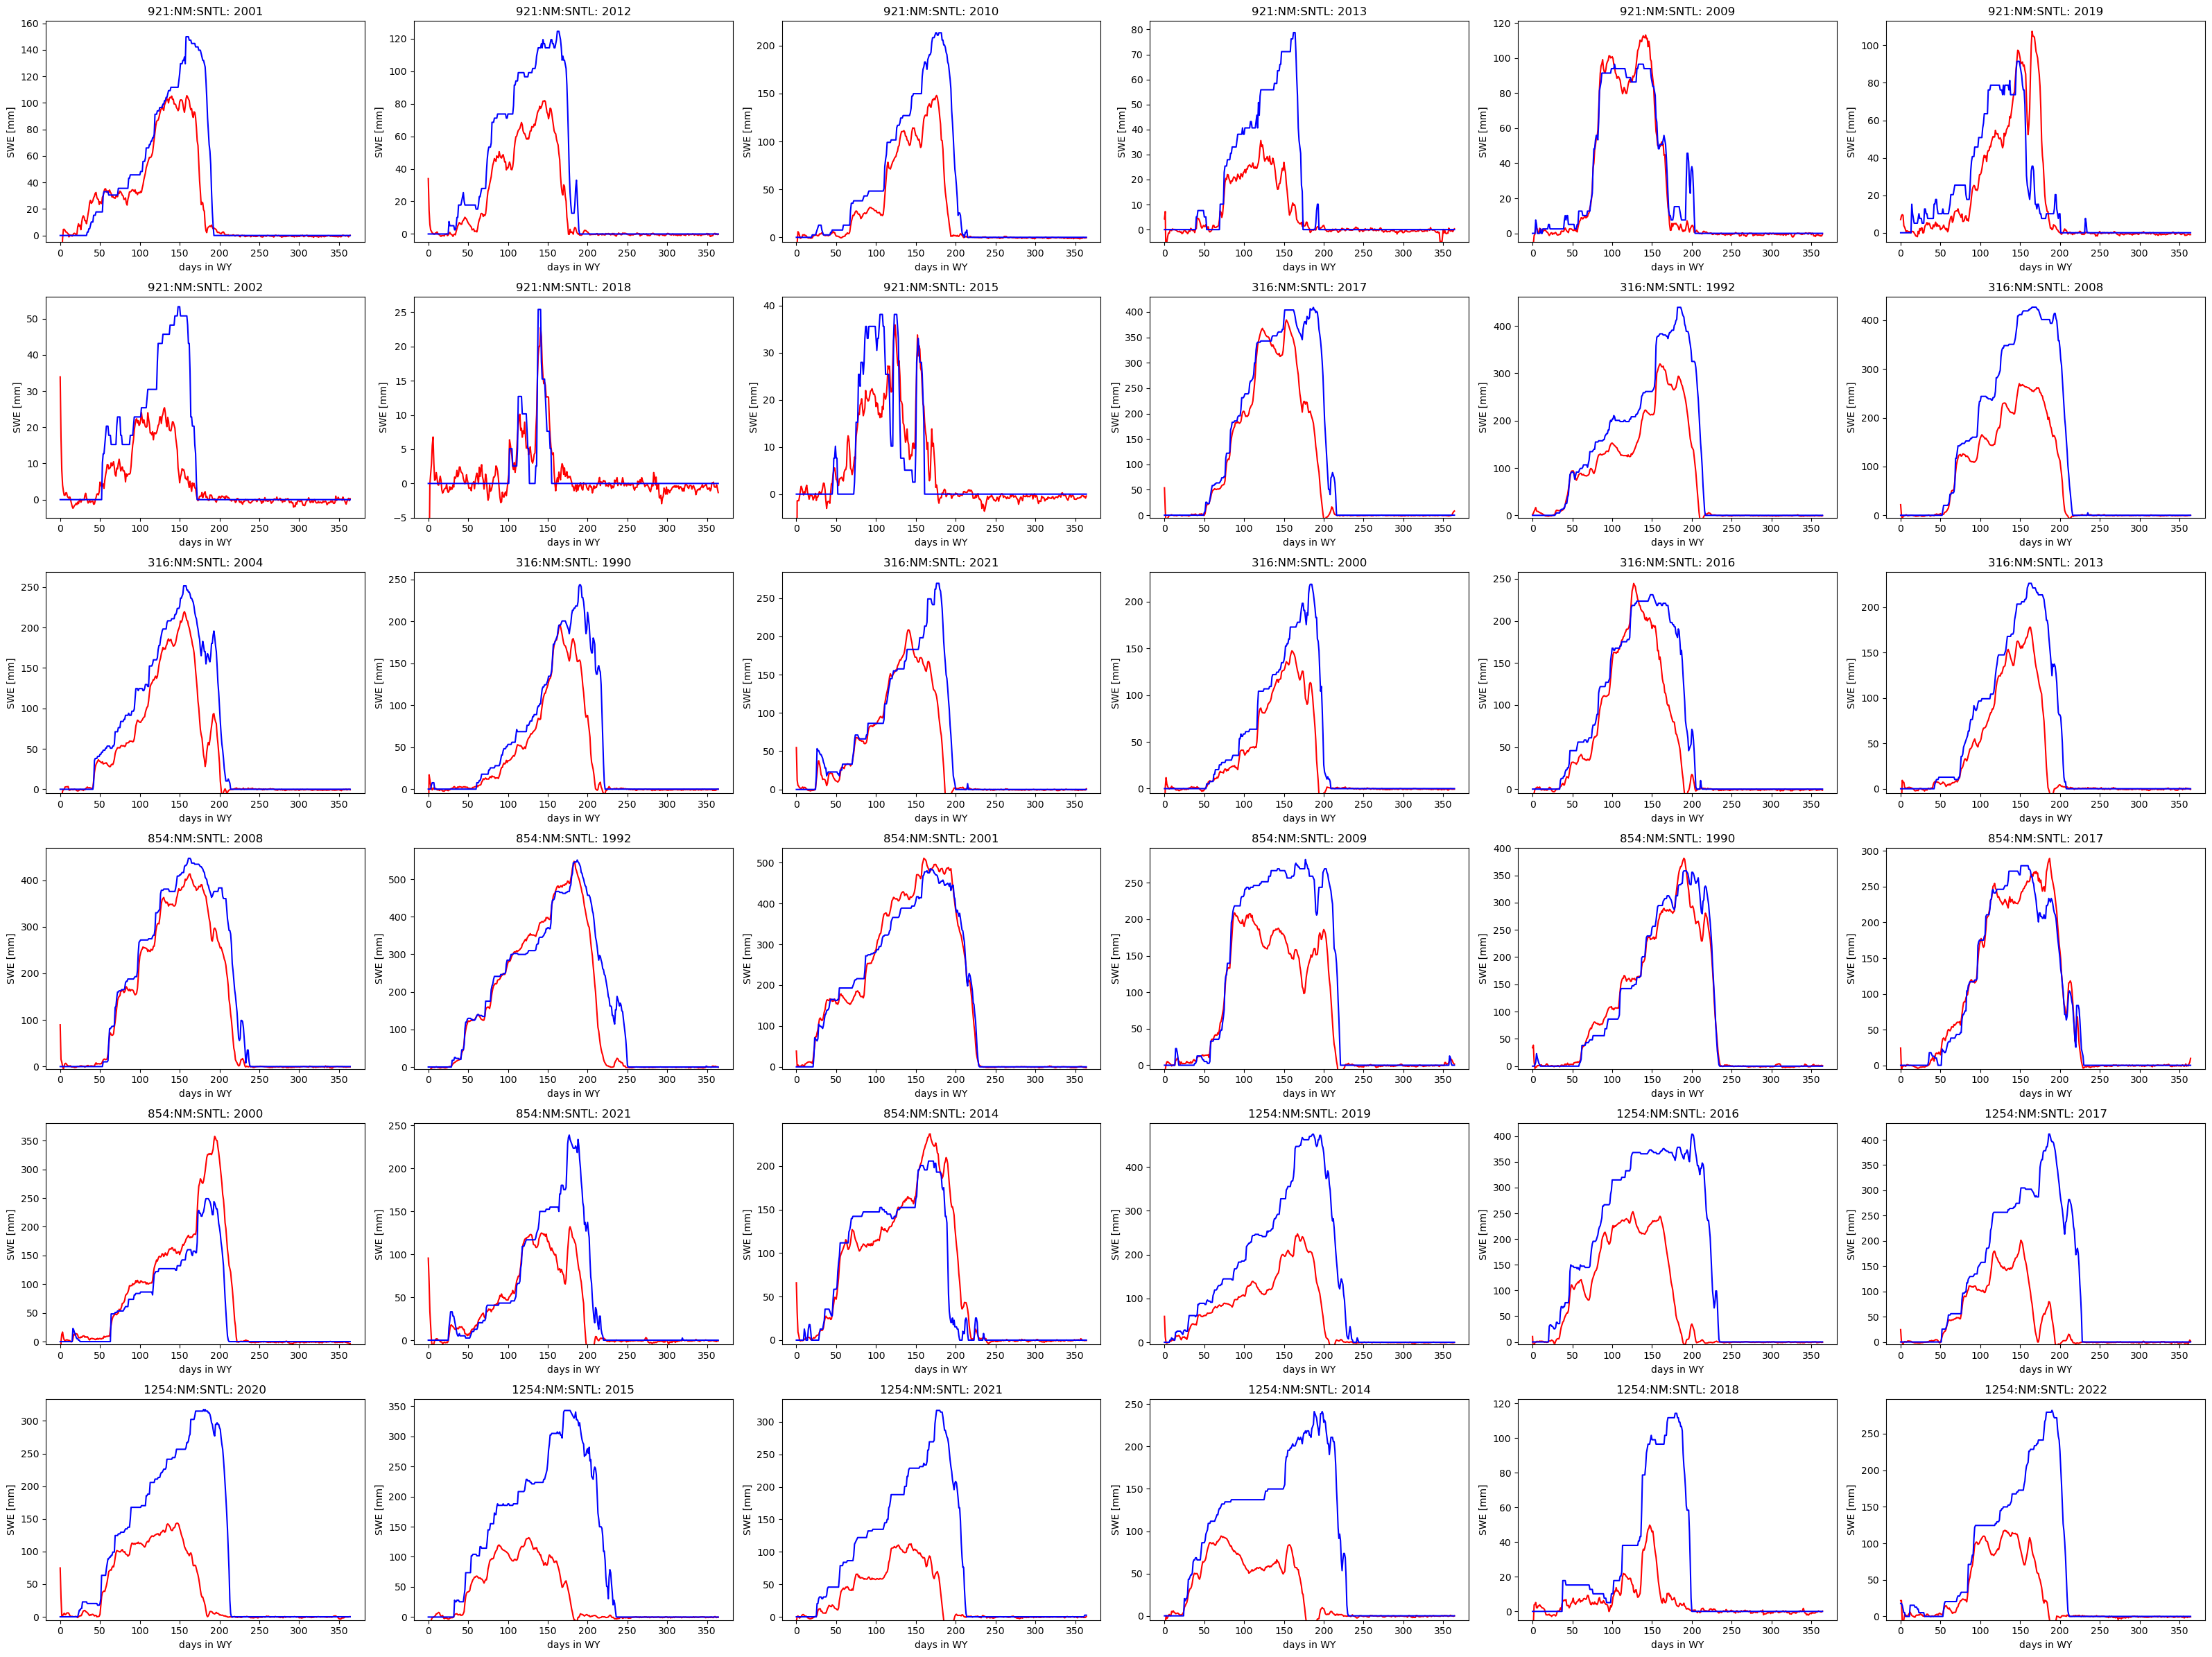

In [9]:
# SINGLE LSTM MODEL
run = 'l9_500'

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

data_test = pd.read_csv('/home/mcburns/national_lstm/national_test_years.txt', sep=' ',header=None)
data_test.columns = ['site_id',	'year',	'train']

ev_lstm = torch.load('/home/mcburns/national_lstm/Data/LSTM_output/'+run+'_lstm.pt', map_location = DEVICE)
test_swe = torch.load('/home/mcburns/national_lstm/Data/LSTM_output/'+run+'_test_swe.pt')
test_non_swe = torch.load('/home/mcburns/national_lstm/Data/LSTM_output/'+run+'_test_non_swe.pt')
with open('/home/mcburns/national_lstm/Data/LSTM_output/'+run+'_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe = l_normalize[0]

# GET PARFLOW RESULTS FOR EACH SITE
plt.figure(figsize=(32,24))
for i in range(0, len(data_test)):
    site_id = data_test['site_id'][i]
    year = data_test['year'][i]
    start_date = str(year-1) + '-10-01'
    end_date = str(year) + '-09-30'

    test_swe_tensors = test_swe[i]
    
    test_non_swe_tensors = torch.reshape(test_non_swe[i], (test_non_swe[i].shape[0], 1, test_non_swe[i].shape[1])).to(DEVICE)
    swe_pred = ev_lstm(test_non_swe_tensors)
    swe_pred = scaler_swe.inverse_transform(swe_pred.cpu().detach().numpy().reshape(-1,1))
    
    swe_obs = scaler_swe.inverse_transform(test_swe_tensors.cpu().detach().numpy().reshape(-1,1))

    # for regional/national model:
    if (i < 36):
        plt.subplot(6, 6, i+1)
        # blue is actual, green is predicted
        plt.plot(swe_pred, label='LSTM', c='#e41a1c')
        plt.plot(swe_obs, label='SNOTEL', c='#377eb8')
        plt.title(site_id + ': '+ str(year))
        plt.xlabel('days in WY')
        plt.ylabel('SWE [mm]')
        plt.ylim(bottom=-5)

plt.tight_layout()

In [4]:
run='l9_500' 
total_statistics_lstm = pd.read_csv('/home/mcburns/national_lstm/Data/LSTM_output/'+run+'_statistics.txt',sep=' ',header=None)
total_statistics_lstm.columns = ['rmse','normal rmse','nse','r2','spearman_rho','delta peak','normal delta peak','abs delta peak','normal abs delta peak',
                                 'delta days','abs delta days']

# Analysis and model comparison

## Compare metrics

In [164]:
## COMBINE DATA - FULL ##
total_statistics['model'] = 'UA SWE'
total_statistics_pf['model'] = 'PFCLM'
total_statistics_lstm['model'] = 'LSTM'

model_statistics = pd.concat([total_statistics, total_statistics_pf, total_statistics_lstm], ignore_index=True)
model_statistics['normal delta days'] = model_statistics['delta days']/365

In [104]:
# Min-Max Normalization function
def min_max_normalize(column):
    return (column - column.min()) / (column.max() - column.min())

# z score normalization function
def z_score_normalize(column):
    return (column - column.mean()) / column.std()

model_statistics_normalized = model_statistics.drop(['model'], axis=1).drop(model_statistics['nse'].idxmin()).apply(min_max_normalize)
model_statistics_normalized['model'] = model_statistics['model']

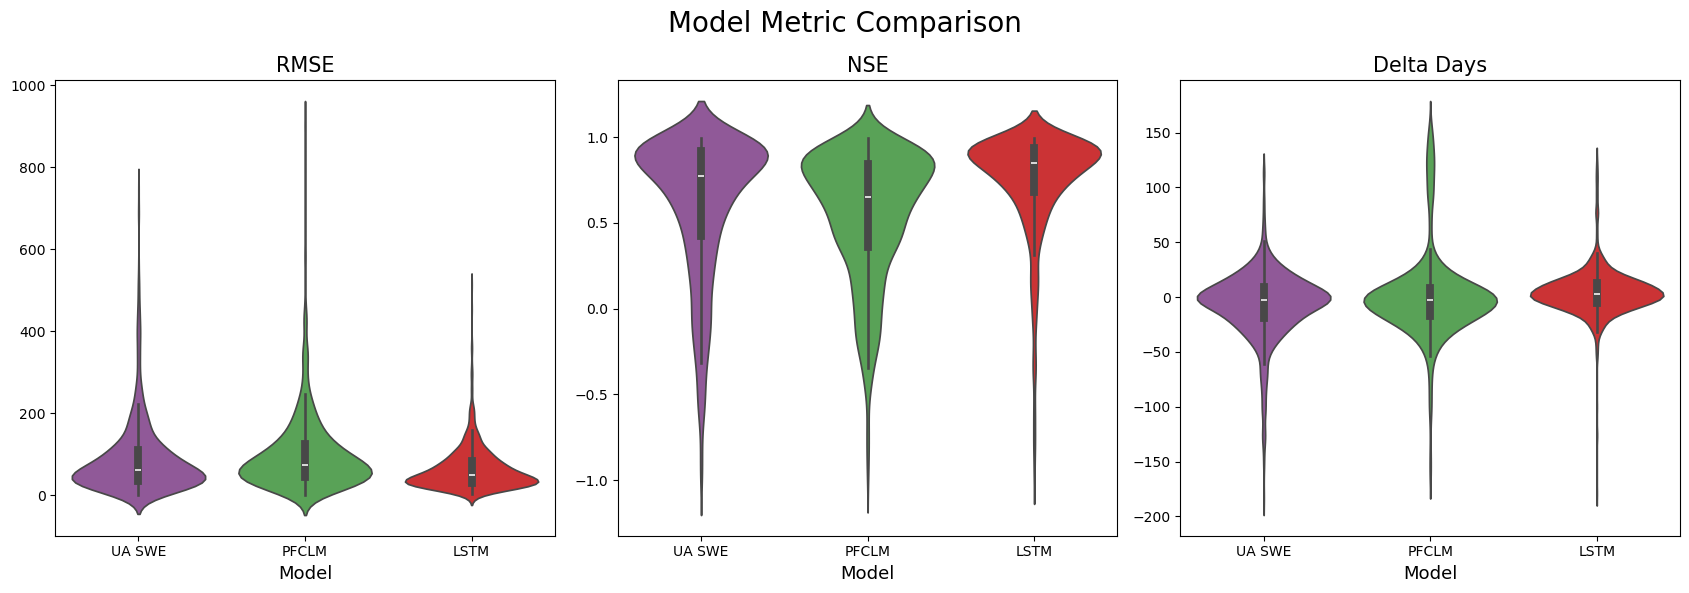

In [123]:
## VIOLIN PLOT ##
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 6))
custom_palette = ['#984ea3', '#4daf4a', '#e41a1c']

# RMSE
sns.violinplot(x='model', y='rmse', hue='model', data=model_statistics[model_statistics['rmse']<1000], ax=axes[0], palette=custom_palette)
axes[0].set_title('RMSE', fontsize=15)
axes[0].set_xlabel('Model', fontsize=13)
axes[0].set_ylabel('')

# NSE
# removed extreme metrics to make it visually make sense - reconsider
sns.violinplot(x='model', y='nse', hue='model', data=model_statistics[model_statistics['nse']>-1], ax=axes[1], palette=custom_palette)
axes[1].set_title('NSE', fontsize=15)
axes[1].set_xlabel('Model', fontsize=13)
axes[1].set_ylabel('')

# Abs Delta Peak
sns.violinplot(x='model', y='delta days', hue='model', data=model_statistics, ax=axes[2], palette=custom_palette)
axes[2].set_title('Delta Days', fontsize=15)
axes[2].set_xlabel('Model', fontsize=13)
axes[2].set_ylabel('')

# plot things
fig.suptitle('Model Metric Comparison', size=20)
plt.tight_layout()

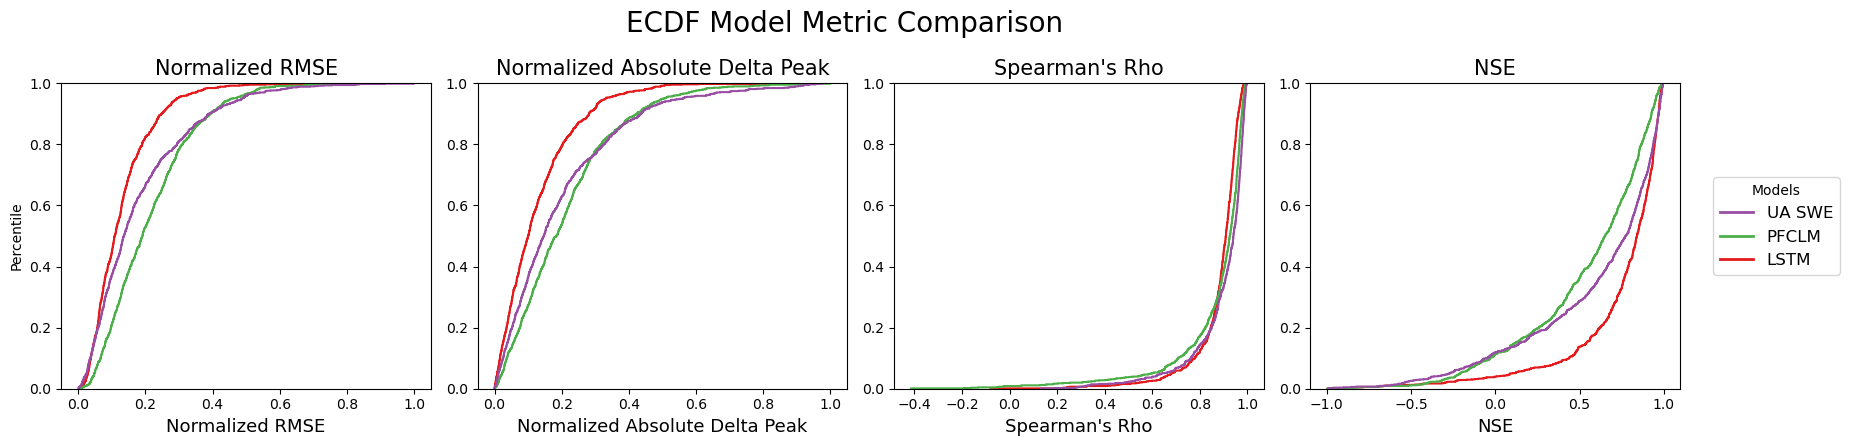

In [142]:
## ECDF plots ##
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(17, 4.5))
custom_palette = ['#984ea3', '#4daf4a', '#e41a1c']

# RMSE
sns.ecdfplot(data=model_statistics_normalized, x='normal rmse', hue='model', ax=axes[0], palette=custom_palette, legend=False)
axes[0].set_title('Normalized RMSE', fontsize=15)
axes[0].set_xlabel('Normalized RMSE', fontsize=13)
axes[0].set_ylabel('Percentile')

# Abs Delta Peak
sns.ecdfplot(data=model_statistics_normalized, x='normal abs delta peak', hue='model', ax=axes[1], palette=custom_palette, legend=False)
axes[1].set_title('Normalized Absolute Delta Peak', fontsize=15)
axes[1].set_xlabel('Normalized Absolute Delta Peak', fontsize=13)
axes[1].set_ylabel('')

# Spearman rho
sns.ecdfplot(data=model_statistics, x='spearman_rho', hue='model', ax=axes[2], palette=custom_palette, legend=False)
axes[2].set_title('Spearman\'s Rho', fontsize=15)
axes[2].set_xlabel('Spearman\'s Rho', fontsize=13)
axes[2].set_ylabel('')

# NSE
# removed extreme metrics to make it visually make sense - reconsider
sns.ecdfplot(data=model_statistics[model_statistics['nse']>-1], x='nse', hue='model', ax=axes[3], palette=custom_palette, legend=False)
axes[3].set_title('NSE', fontsize=15)
axes[3].set_xlabel('NSE', fontsize=13)
axes[3].set_ylabel('')

# plot things
fig.legend([plt.Line2D([0], [0], color=color, lw=2) for color in custom_palette], model_statistics_normalized['model'].unique(),
           title='Models', loc='center right', bbox_to_anchor=(1.09, 0.5), fontsize=12)
fig.suptitle('ECDF Model Metric Comparison', size=20)
plt.tight_layout()

## Compare performance across snowpack regimes

In [5]:
## GET DATA ##

# Define a function to categorize states
def categorize_state(state):
    if state in ['WA', 'OR', 'CA']:
        return 'Maritime'
    elif state in ['MT','UT','ID','NV']:
        return 'Intermountain'
    elif state in ['CO','NM','AZ','WY']:
        return 'Continental'

run = 'l9_500'
data = pd.read_csv('/home/mcburns/national_lstm/Data/LSTM_output/test_metadata.csv', sep=' ', header=None)
data.columns=['site_id','year','train','latitude','longitude','elevation','land cover','slope_x','slope_y']
data['state'] = np.array(x.split(':')[1] for x in data['site_id'])
data['Regime'] = data['state'].apply(categorize_state)

# merge statistics
total_ua = pd.concat([data, total_statistics], axis=1)
total_pf = pd.concat([data, total_statistics_pf], axis=1)
total_lstm = pd.concat([data, total_statistics_lstm], axis=1)

total = pd.concat([total_ua, total_pf, total_lstm], ignore_index=True)

# divide by location
#maritime = pd.concat([total[total.state == 'WA'], total[total.state == 'OR'], total[total.state == 'CA']]).reset_index()
#intermountain = pd.concat([total[total.state == 'MT'], total[total.state == 'UT'], total[total.state == 'ID'], total[total.state == 'NV']])
#continental = pd.concat([total[total.state == 'CO'], total[total.state == 'NM'], total[total.state == 'AZ'], total[total.state == 'WY']])

# figure out mean statistics
#print('RMSE for maritime', np.mean(maritime['NSE']))
#print('RMSE for intermountain', np.mean(intermountain['NSE']))
#print('RMSE for continental', np.mean(continental['NSE']))

In [26]:
total.groupby('Regime').agg({'rmse': 'mean', 'normal rmse':'mean','nse':'mean', 'normal abs delta peak':'mean', 'delta days':'mean'})

rmse  normal rmse       nse  normal abs delta peak  \
Regime                                                                    
Continental     80.442692     0.207206  0.495813               0.339211   
Intermountain   80.369921     0.207046  0.506261               0.333063   
Maritime       104.937064     0.225530 -1.134942               0.376249   

               delta days  
Regime                     
Continental      0.335648  
Intermountain   -1.308308  
Maritime        -0.306243

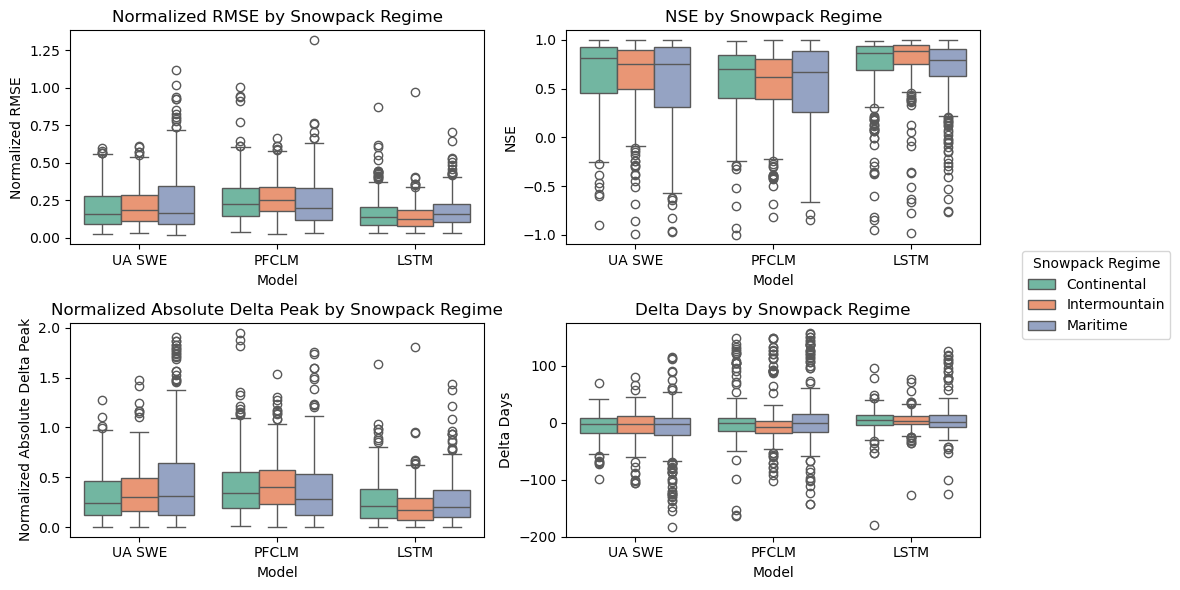

In [135]:
## MAKE PLOTS ##
fig, axes = plt.subplots(2, 2, figsize=(10, 6))  # 2x2 grid of subplots

y_var = ['normal rmse', 'nse', 'normal abs delta peak', 'delta days']
y_var_names = ['Normalized RMSE','NSE','Normalized Absolute Delta Peak', 'Delta Days']

for i, y in enumerate(y_var):
    ax = axes[i // 2, i % 2]  # Map subplot positions
    if y=='nse':
        sns.boxplot(x='model', y=y, hue='Regime', data=total[total['nse']>-1], palette='Set2', ax=ax, dodge=True)
    else: sns.boxplot(x='model', y=y, hue='Regime', data=total, palette='Set2', ax=ax, dodge=True)
    ax.set_xlabel('Model')
    ax.set_ylabel(y_var_names[i])
    ax.set_title(f'{y_var_names[i]} by Snowpack Regime')
    ax.legend_.remove()

handles, labels = axes[0, 0].get_legend_handles_labels() 
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5), ncol=1, title='Snowpack Regime')

plt.tight_layout()

# sns.boxplot(x='model', y='normal rmse', hue='Regime', data=total, palette='Set2')
# plt.xlabel('Model')
# plt.ylabel('Normalized RMSE')
# plt.title('')

## Plot representative years

### add meteorological data

In [187]:
met_data

precip       temp  elevation   latitude   longitude        DSWR  \
0      0.00  20.100000     3650.0  45.428699 -121.856056  212.042374   
1      0.00  18.000000     3650.0  45.428699 -121.856056  205.171371   
2      0.00  17.100000     3650.0  45.428699 -121.856056  204.344513   
3      0.00  13.400000     3650.0  45.428699 -121.856056  196.449265   
4      0.00  11.000000     3650.0  45.428699 -121.856056  196.314087   
..      ...        ...        ...        ...         ...         ...   
360    0.00   9.000000     3650.0  45.428699 -121.856056   78.801765   
361    0.00  11.900001     3650.0  45.428699 -121.856056  199.109680   
362    0.00  18.200001     3650.0  45.428699 -121.856056  198.867065   
363    5.08  15.900000     3650.0  45.428699 -121.856056  125.368477   
364    0.00   7.100000     3650.0  45.428699 -121.856056   90.415642   

           DLWR  wind (E)  wind (N)      pressure         q  land_cover  \
0    297.528015 -5.114876  0.498932  89555.242188  0.006741         1.0   
1    304.514404 -2.245934 -0.374105  89423.906250  0.008363         1.0   
2    300.884033  1.940667 -1.376477  89445.500000  0.008822         1.0   
3    295.836700  3.341970 -0.726745  89355.203125  0.008788         1.0   
4    326.876862  3.425322 -1.619592  89579.914062  0.008547         1.0   
..          ...       ...       ...           ...       ...         ...   
360  339.164703  2.749876  0.529232  89198.257812  0.009198         1.0   
361  276.574463 -0.244684 -1.787959  89449.273438  0.006055         1.0   
362  276.467804 -5.886580 -0.611904  89644.335938  0.005381         1.0   
363  320.136230 -1.518168 -1.167627  89307.414062  0.007691         1.0   
364  362.605682  7.669667  0.196963  89331.968750  0.011008         1.0   

     slope_x  slope_y  
0      0.019 -0.08905  
1      0.019 -0.08905  
2      0.019 -0.08905  
3      0.019 -0.08905  
4      0.019 -0.08905  
..       ...      ...  
360    0.019 -0.08905  
361    0.019 -0.08905  
362    0.019 -0.08905  
363    0.019 -0.08905  
364    0.019 -0.08905  

[365 rows x 14 columns]

/tmp/ipykernel_1081728/3425457703.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm = torch.load('Data/LSTM_output/'+run+'_lstm.pt', map_location = DEVICE)
/tmp/ipyk

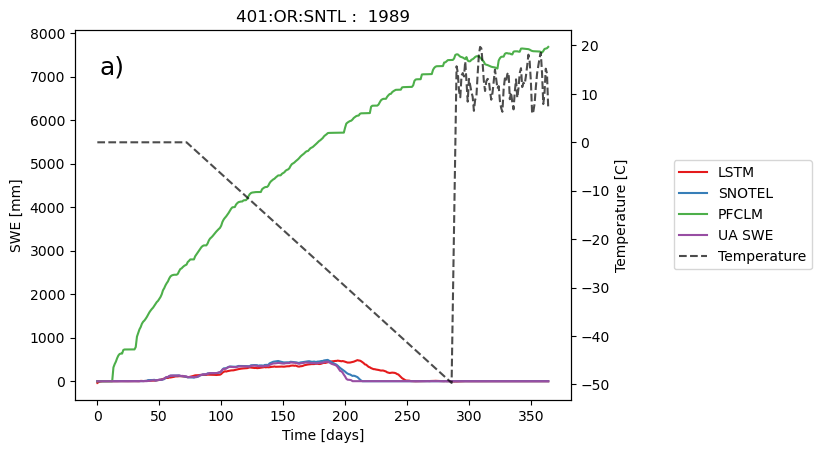

In [33]:
# single year

# data about test year/site
# 65 and 666 are years with meterological errors AND 110; 64 is year with cutoff PFCLM
i = 666
site_id = total_lstm.loc[i, 'site_id']
year = int(total_lstm.loc[i, 'year'])
test_metadata = pd.read_csv('/home/mcburns/national_lstm/Data/LSTM_output/'+run+'_test_metadata.csv', sep=' ')
ind = test_metadata.loc[(test_metadata['site_id'] == site_id) & (test_metadata['year'] == year)].index[0]

# UA SWE 
lat = test_metadata['latitude'][ind]
lon = test_metadata['longitude'][ind]

for j in np.arange(1, len(lat_values)):
    l_current = lat_values[j]
    if (lat <= l_current): #and (lat > l_last):
        lat_coord = lat_values[j-1]      #i-1
        break
for j in np.arange(1, len(lon_values)):
    l_last = lon_values[j-1]
    l_current = lon_values[j]
    if (lat >= l_last) and (lon < l_current):
        lon_coord = lon_values[j-1]
        break
        
model = xr.open_dataset('Data/UA_SWE/4km_SWE_Depth_WY'+str(year)+'_v01.nc')
swe_ua = model.sel(lat=lat_coord, lon=lon_coord)['SWE'].values

# PFCLM and actual SWE
swe_clm, swe_actual = prod_swe(site_id, year)

# LSTM model predictions
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

lstm = torch.load('Data/LSTM_output/'+run+'_lstm.pt', map_location = DEVICE)
test_swe = torch.load('Data/LSTM_output/'+run+'_test_swe.pt')
test_non_swe = torch.load('Data/LSTM_output/'+run+'_test_non_swe.pt')
with open('Data/LSTM_output/'+run+'_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe = l_normalize[0]

test_non_swe_tensors = torch.reshape(test_non_swe[ind], (test_non_swe[ind].shape[0], 1,test_non_swe[ind].shape[1])).to(DEVICE)
swe_pred = lstm(test_non_swe_tensors)
swe_pred = scaler_swe.inverse_transform(swe_pred.cpu().detach().numpy().reshape(-1,1))
test_swe = scaler_swe.inverse_transform(test_swe[ind].cpu().detach().numpy().reshape(-1,1))

# get meteorological data (precip in mm, temp in C)
met_data = pd.DataFrame(test_non_swe_tensors.squeeze().detach().numpy(), columns=['precip','temp','elevation','latitude','longitude','DSWR','DLWR',
                                                                                  'wind (E)','wind (N)', 'pressure','q','land_cover','slope_x','slope_y'])
for col, scaler in zip(met_data.columns, l_normalize[1:]):
    met_data[col] = scaler.inverse_transform(met_data[[col]])

# first plot
fig, ax1 = plt.subplots()
sns.set_palette("Set1") 
ax1.plot(swe_pred, label='LSTM',c='#e41a1c')
ax1.plot(swe_actual['swe'], label='SNOTEL',c='#377eb8')
ax1.plot(swe_clm, label='PFCLM', c='#4daf4a')
ax1.plot(swe_ua, label='UA SWE', c='#984ea3')
ax1.set_ylabel('SWE [mm]')
ax2 = ax1.twinx()
ax2.plot(met_data['temp'], c='black', linestyle='--', alpha = 0.7, label='Temperature')
ax2.set_ylabel('Temperature [C]')
ax1.text(0.05, 0.88, 'a)', fontsize=18, transform=ax1.transAxes)

ax1.set_xlabel('Time [days]') 
plt.title(site_id + ' :  '+str(year))
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 'center right', bbox_to_anchor=(1.5, 0.5))


### worst performing year for specific models

In [185]:
## FIND WORST PERFORMING YEAR FOR SPECIFIC MODELS ##
# exclude years 666 and 65 because they have missing/erroneous meteorological data
#total_ua, total_pf, total_lstm
total_ua = total_ua.drop([666, 65, 110])
total_pf = total_pf.drop([666, 65, 110])
total_lstm = total_lstm.drop([666, 65, 110])
worst_model_performance = pd.DataFrame({'Model': ['LSTM', 'PFCLM','UA SWE','LSTM','PFCLM','UA SWE'], 
                                        'Metric': ['rmse', 'rmse', 'rmse', 'nse', 'nse', 'nse'], 
                                        'Index': [total_lstm['rmse'].idxmax(), total_pf['rmse'].idxmax(), total_ua['rmse'].idxmax(), total_lstm['nse'].idxmin(), 
                                                  total_pf['nse'].idxmin(), total_ua['nse'].idxmin()],
                                       'site_id':[total_lstm.loc[total_lstm['rmse'].idxmax(), 'site_id'], total_pf.loc[total_pf['rmse'].idxmax(), 'site_id'],
                                                  total_ua.loc[total_ua['rmse'].idxmax(), 'site_id'], total_lstm.loc[total_lstm['nse'].idxmin(), 'site_id'],
                                                  total_pf.loc[total_pf['nse'].idxmin(), 'site_id'], total_ua.loc[total_ua['nse'].idxmin(), 'site_id']],
                                       'year':[total_lstm.loc[total_lstm['rmse'].idxmax(), 'year'], total_pf.loc[total_pf['rmse'].idxmax(), 'year'],
                                               total_ua.loc[total_ua['rmse'].idxmax(), 'year'], total_lstm.loc[total_lstm['nse'].idxmin(), 'year'], 
                                               total_pf.loc[total_pf['nse'].idxmin(), 'year'], total_ua.loc[total_ua['nse'].idxmin(), 'year']],
                                       'rmse':[total_lstm.loc[total_lstm['rmse'].idxmax(), 'rmse'], total_pf.loc[total_pf['rmse'].idxmax(), 'rmse'],
                                               total_ua.loc[total_ua['rmse'].idxmax(), 'rmse'], total_lstm.loc[total_lstm['nse'].idxmin(), 'rmse'], 
                                               total_pf.loc[total_pf['nse'].idxmin(), 'rmse'], total_ua.loc[total_ua['nse'].idxmin(), 'rmse']],
                                       'nse':[total_lstm.loc[total_lstm['rmse'].idxmax(), 'nse'], total_pf.loc[total_pf['rmse'].idxmax(), 'nse'],
                                               total_ua.loc[total_ua['rmse'].idxmax(), 'nse'], total_lstm.loc[total_lstm['nse'].idxmin(), 'nse'], 
                                               total_pf.loc[total_pf['nse'].idxmin(), 'nse'], total_ua.loc[total_ua['nse'].idxmin(), 'nse']],})
worst_model_performance

Model Metric  Index      site_id  year         rmse         nse
0    LSTM   rmse    889  681:WA:SNTL  1991   454.025513    0.470193
1   PFCLM   rmse    684  351:OR:SNTL  1989  1225.350737   -6.303498
2  UA SWE   rmse    881  974:WA:SNTL  2011   748.926537   -0.536449
3    LSTM    nse    206  473:CA:SNTL  2015    12.263681  -22.203564
4   PFCLM    nse    671  401:OR:SNTL  1992   222.262129 -247.353684
5  UA SWE    nse    204  473:CA:SNTL  2000   127.262105  -12.119178

/tmp/ipykernel_642690/1668746347.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm = torch.load('Data/LSTM_output/'+run+'_lstm.pt', map_location = DEVICE)
/tmp/ipyke

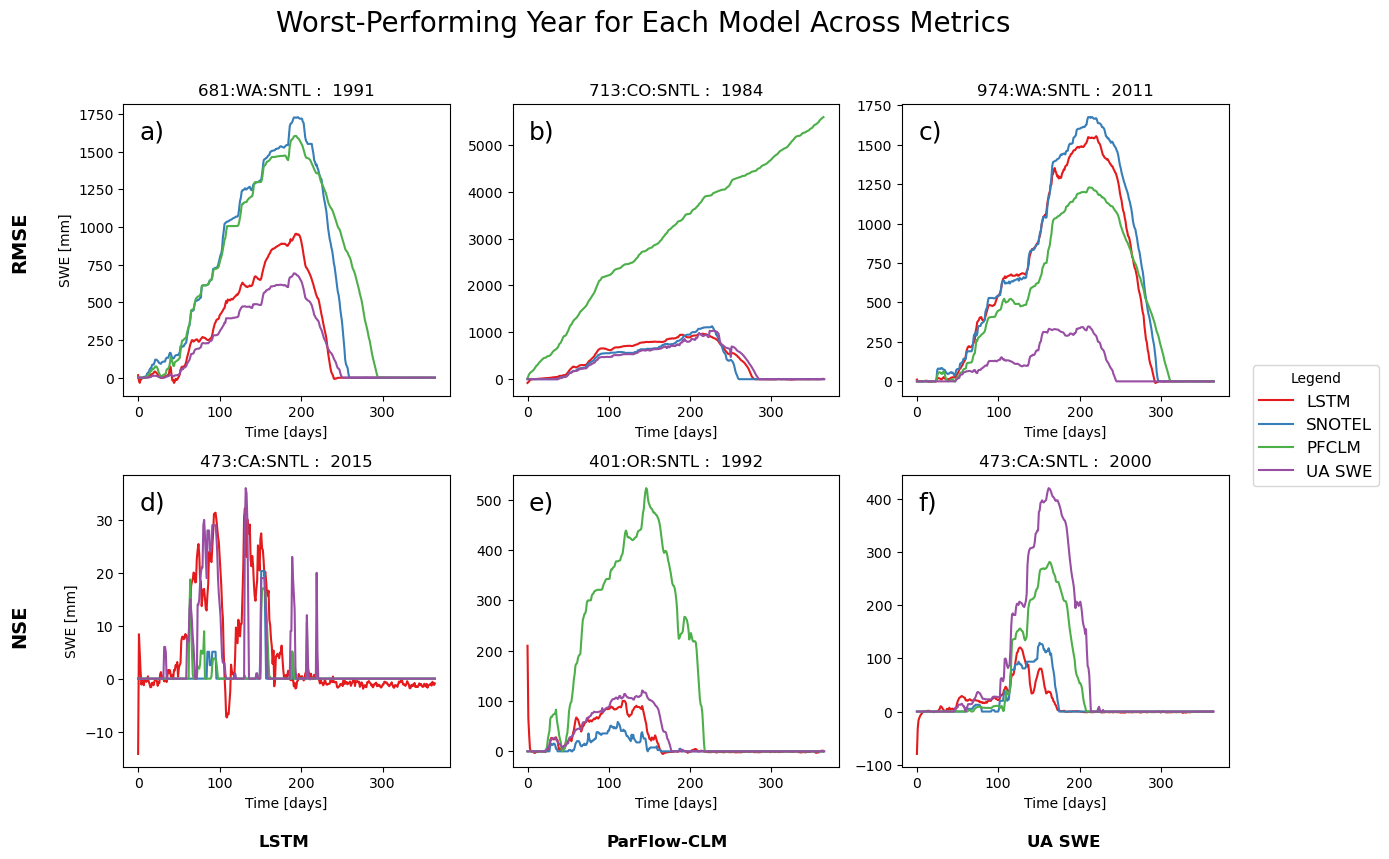

In [170]:
## REPRESENTATIVE YEARS ##
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axes = axes.flatten()
labels=['a)','b)','c)','d)','e)','f)']

for i in range(0,len(worst_model_performance)):
    # data about test year/site
    site_id = worst_model_performance.loc[i, 'site_id']
    year = int(worst_model_performance.loc[i, 'year'])
    test_metadata = pd.read_csv('/home/mcburns/national_lstm/Data/LSTM_output/'+run+'_test_metadata.csv', sep=' ')
    ind = test_metadata.loc[(test_metadata['site_id'] == site_id) & (test_metadata['year'] == year)].index[0]
    
    # UA SWE 
    lat = test_metadata['latitude'][ind]
    lon = test_metadata['longitude'][ind]
    
    for j in np.arange(1, len(lat_values)):
        l_current = lat_values[j]
        if (lat <= l_current): #and (lat > l_last):
            lat_coord = lat_values[j-1]      #i-1
            break
    for j in np.arange(1, len(lon_values)):
        l_last = lon_values[j-1]
        l_current = lon_values[j]
        if (lat >= l_last) and (lon < l_current):
            lon_coord = lon_values[j-1]
            break
            
    model = xr.open_dataset('Data/UA_SWE/4km_SWE_Depth_WY'+str(year)+'_v01.nc')
    swe_ua = model.sel(lat=lat_coord, lon=lon_coord)['SWE'].values
    
    # PFCLM and actual SWE
    swe_clm, swe_actual = prod_swe(site_id, year)
    
    # LSTM model
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    lstm = torch.load('Data/LSTM_output/'+run+'_lstm.pt', map_location = DEVICE)
    test_swe = torch.load('Data/LSTM_output/'+run+'_test_swe.pt')
    test_non_swe = torch.load('Data/LSTM_output/'+run+'_test_non_swe.pt')
    with open('Data/LSTM_output/'+run+'_normalize.pkl', 'rb') as file:  
        l_normalize = pickle.load(file)
    scaler_swe = l_normalize[0]
    
    test_non_swe_tensors = torch.reshape(test_non_swe[ind], (test_non_swe[ind].shape[0], 1,test_non_swe[ind].shape[1])).to(DEVICE)
    swe_pred = lstm(test_non_swe_tensors)
    swe_pred = scaler_swe.inverse_transform(swe_pred.cpu().detach().numpy().reshape(-1,1))
    test_swe = scaler_swe.inverse_transform(test_swe[ind].cpu().detach().numpy().reshape(-1,1))
    
    # plot
    sns.set_palette("Set1") 
    axes[i].plot(swe_pred, label='LSTM',c='#e41a1c')
    axes[i].plot(swe_actual['swe'], label='SNOTEL',c='#377eb8')
    axes[i].plot(swe_clm, label='PFCLM', c='#4daf4a')
    axes[i].plot(swe_ua, label='UA SWE', c='#984ea3')
    axes[i].text(0.05, 0.88, labels[i], fontsize=18, transform=axes[i].transAxes)
    #plt.ylim([-5,110])
    if i==0 or i==3:
        axes[i].set_ylabel('SWE [mm]')
    axes[i].set_xlabel('Time [days]') 
    axes[i].set_title(site_id + ' :  '+str(year))
    #plt.legend()

# row labels
fig.text(-0.02, 0.73, "RMSE", ha='center', va='center', rotation=90, fontsize=14, fontweight='bold')
fig.text(-0.02, 0.25, "NSE", ha='center', va='center', rotation=90, fontsize=14, fontweight='bold')
# column labels
fig.text(0.2, -0.02, 'LSTM', ha='center', va='center', rotation=0, fontsize=12, fontweight='bold')
fig.text(0.52, -0.02, "ParFlow-CLM", ha='center', va='center', rotation=0, fontsize=12, fontweight='bold')
fig.text(0.85, -0.02, "UA SWE", ha='center', va='center', rotation=0, fontsize=12, fontweight='bold')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", title="Legend", bbox_to_anchor=(1.12, 0.5), fontsize=12)

plt.suptitle("Worst-Performing Year for Each Model Across Metrics", fontsize=20, y=1.02)

plt.tight_layout()

/tmp/ipykernel_1081728/2435754701.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm = torch.load('Data/LSTM_output/'+run+'_lstm.pt', map_location = DEVICE)
/tmp/ipyk

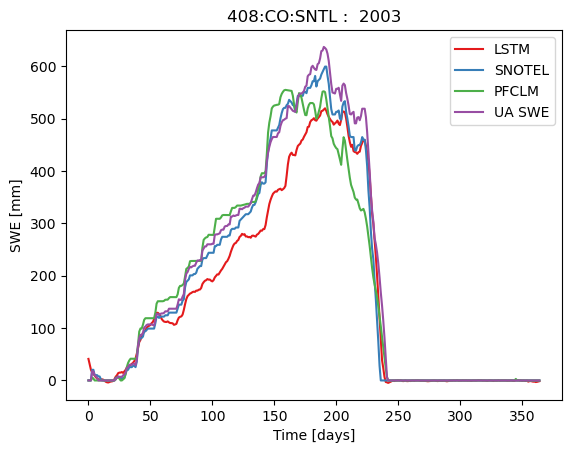

In [20]:
# single year

# data about test year/site
i = 300
site_id = total_lstm.loc[i, 'site_id']
year = int(total_lstm.loc[i, 'year'])
test_metadata = pd.read_csv('/home/mcburns/national_lstm/Data/LSTM_output/'+run+'_test_metadata.csv', sep=' ')
ind = test_metadata.loc[(test_metadata['site_id'] == site_id) & (test_metadata['year'] == year)].index[0]

# UA SWE 
lat = test_metadata['latitude'][ind]
lon = test_metadata['longitude'][ind]

for j in np.arange(1, len(lat_values)):
    l_current = lat_values[j]
    if (lat <= l_current): #and (lat > l_last):
        lat_coord = lat_values[j-1]      #i-1
        break
for j in np.arange(1, len(lon_values)):
    l_last = lon_values[j-1]
    l_current = lon_values[j]
    if (lat >= l_last) and (lon < l_current):
        lon_coord = lon_values[j-1]
        break
        
model = xr.open_dataset('Data/UA_SWE/4km_SWE_Depth_WY'+str(year)+'_v01.nc')
swe_ua = model.sel(lat=lat_coord, lon=lon_coord)['SWE'].values

# PFCLM and actual SWE
swe_clm, swe_actual = prod_swe(site_id, year)

# LSTM model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

lstm = torch.load('Data/LSTM_output/'+run+'_lstm.pt', map_location = DEVICE)
test_swe = torch.load('Data/LSTM_output/'+run+'_test_swe.pt')
test_non_swe = torch.load('Data/LSTM_output/'+run+'_test_non_swe.pt')
with open('Data/LSTM_output/'+run+'_normalize.pkl', 'rb') as file:  
    l_normalize = pickle.load(file)
scaler_swe = l_normalize[0]

test_non_swe_tensors = torch.reshape(test_non_swe[ind], (test_non_swe[ind].shape[0], 1,test_non_swe[ind].shape[1])).to(DEVICE)
swe_pred = lstm(test_non_swe_tensors)
swe_pred = scaler_swe.inverse_transform(swe_pred.cpu().detach().numpy().reshape(-1,1))
test_swe = scaler_swe.inverse_transform(test_swe[ind].cpu().detach().numpy().reshape(-1,1))

# plot
fig = plt.figure()
sns.set_palette("Set1") 
plt.plot(swe_pred, label='LSTM',c='#e41a1c')
plt.plot(swe_actual['swe'], label='SNOTEL',c='#377eb8')
plt.plot(swe_clm, label='PFCLM', c='#4daf4a')
plt.plot(swe_ua, label='UA SWE', c='#984ea3')
#plt.ylim([-5,110])
plt.ylabel('SWE [mm]')
plt.xlabel('Time [days]') 
plt.title(site_id + ' :  '+str(year))
plt.legend()


(array([  9.,   3.,   7., 189.,  51.,  38.,  29.,  21.,  12.,   6.]),
 array([-88.74214417, -64.53072089, -40.31929761, -16.10787433,
          8.10354895,  32.31497223,  56.52639551,  80.73781879,
        104.94924207, 129.16066534, 153.37208862]),
 <BarContainer object of 10 artists>)

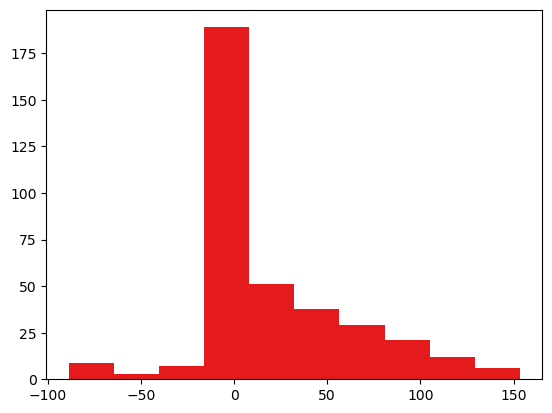

In [21]:
plt.hist(swe_actual['swe'] - swe_pred.flatten())

## Maps

In [111]:
## READ DATA IN ##
test_sites = pd.read_csv('national_test_sites.txt', sep=' ', header=None)
test_sites.columns = ['site_id', 'site_name', 'site_type', 'agency', 'state','first_date_data_available', 'last_date_data_available', 'record_count',
                     'latitude', 'longitude', 'bins','first_wy_date', 'last_wy_date']
test_metadata = pd.read_csv('Data/LSTM_output/test_metadata.csv', sep=' ',header=None)
test_metadata.columns = ['site_id','year','train','latitude','longitude','elevation','land_cover','slope_x','slope_y']

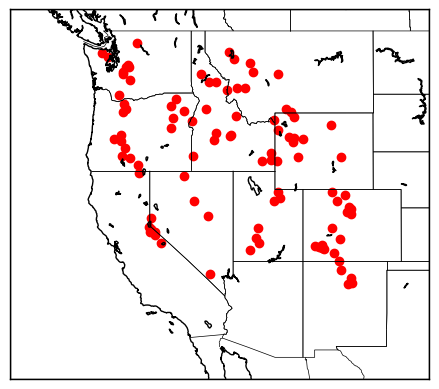

In [112]:
## MAP OF NATIONAL TEST SITES
map = Basemap(projection='merc', llcrnrlon=-130,llcrnrlat=30,urcrnrlon=-100,urcrnrlat=50, resolution = 'i')

map.drawmapboundary()
map.drawcountries()
map.drawcoastlines()
map.drawstates()

# plot test sites
x, y = map(test_sites['longitude'], test_sites['latitude'])
map.scatter(x, y, marker='o',color='r')

# Scatter plot on the map with color based on 'values'
#sc = map.scatter(x, y, c=values, cmap='viridis', marker='o', s=100, edgecolor='k')
#plt.colorbar(sc, label='Value')  # Add a color bar to interpret the values

In [68]:
## MAP OF MODEL PERFORMANCE - GET DATA ##

# read LSTM metrics
run = 'l9_500'
lstm_results = pd.read_csv('Data/LSTM_output/'+run+'_statistics.txt', sep=' ', header=None)
lstm_results.columns = ['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak','normal delta peak', 'abs delta peak', 
               'normal abs delta peak','delta days', 'abs delta days']
lstm_results = pd.concat([lstm_results, test_metadata], axis=1)

# read CLM metrics
clm_results = pd.read_csv('Data/PFCLM_output/national_statistics.txt', sep=' ', header=None)
clm_results.columns = ['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak','normal delta peak', 'abs delta peak', 
               'normal abs delta peak','delta days', 'abs delta days']
clm_results = pd.concat([clm_results, test_metadata], axis=1)

# read UA SWE metrics
ua_results = pd.read_csv('Data/UA_SWE/national_statistics.txt',sep=' ', header=None)
ua_results.columns = ['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak','normal delta peak', 'abs delta peak', 
                      'normal abs delta peak','delta days', 'abs delta days']
ua_results = pd.concat([ua_results, test_metadata], axis=1)

# calculate aggregated data
lstm_results_agg = lstm_results.groupby('site_id').mean().reset_index()
ua_results_agg = ua_results.groupby('site_id').mean().reset_index()
clm_results_agg = clm_results.groupby('site_id').mean().reset_index()

aggs = [lstm_results_agg, ua_results_agg, clm_results_agg]

/tmp/ipykernel_2451657/1404468502.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95])


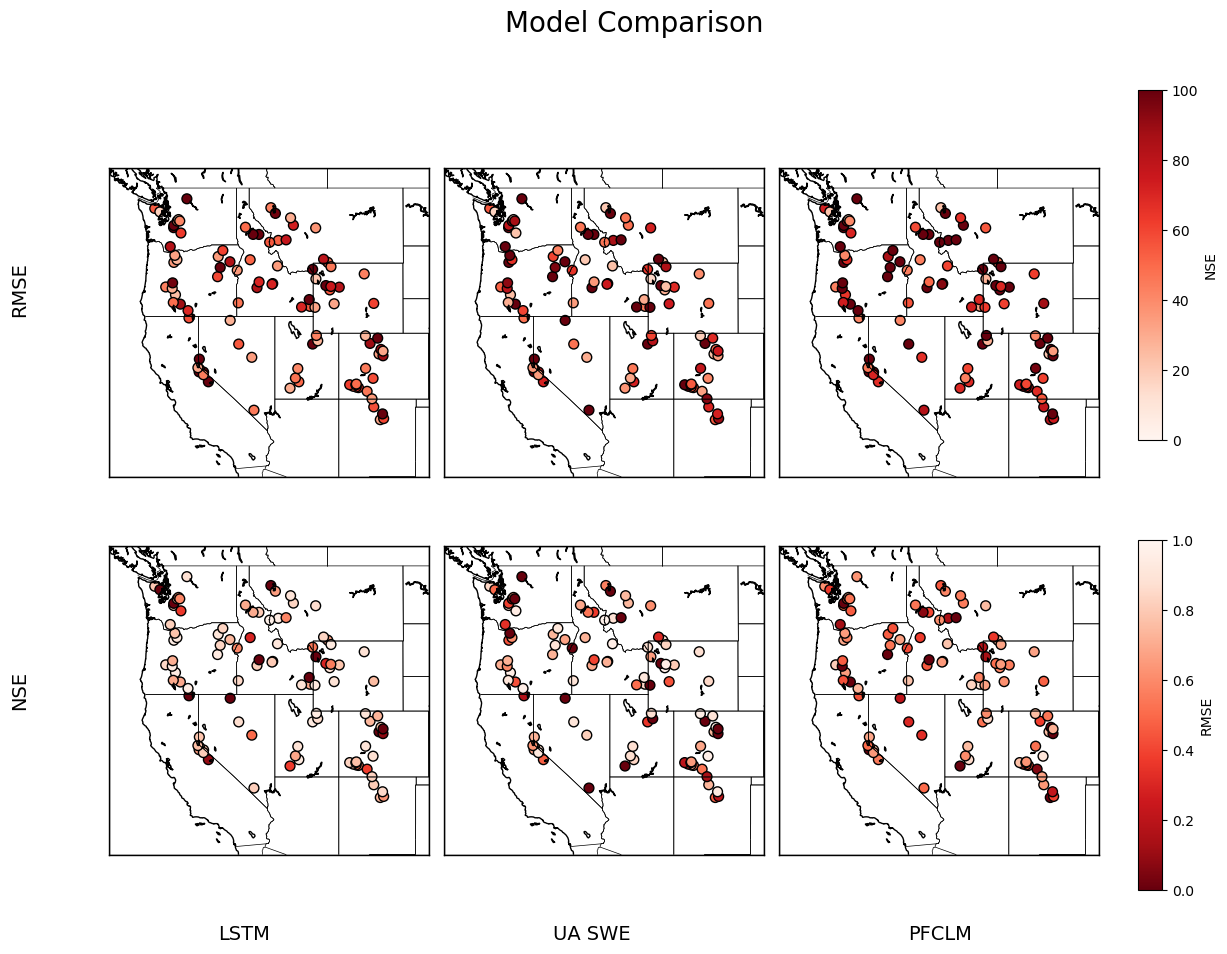

In [151]:
## DOT MAP OF MODEL PERFORMANCE - PLOT ##
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))

for i in range(1,4):
    # coordinates are the same across all aggregated sites
    x, y = map(test_sites['longitude'], test_sites['latitude'])
    
    # plot RMSE
    values = aggs[i-1]['rmse']
    map = Basemap(projection='merc', llcrnrlon=-127,llcrnrlat=32,urcrnrlon=-102,urcrnrlat=50, resolution = 'i', ax=axes[0,i-1])
    sc1 = map.scatter(x, y, c=values, cmap='Reds', vmin=0, vmax=100, marker='o', s=50, edgecolor='k')
    map.drawmapboundary()
    map.drawcountries()
    map.drawcoastlines()
    map.drawstates()
    plt.plot('RMSE for LSTM')

    # plot NSE
    values = aggs[i-1]['nse']
    map = Basemap(projection='merc', llcrnrlon=-127,llcrnrlat=32,urcrnrlon=-102,urcrnrlat=50, resolution = 'i', ax=axes[1,i-1])
    sc2 = map.scatter(x, y, c=values, cmap='Reds_r', vmin=0, vmax=1, marker='o', s=50, edgecolor='k')
    map.drawmapboundary()
    map.drawcountries()
    map.drawcoastlines()
    map.drawstates()

# plot things
plt.suptitle('Model Comparison', fontsize=20)
cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.35])  # Adjust the position and size for the first colorbar
cbar1 = plt.colorbar(sc1, cax=cbar_ax1, label='NSE')  # Add a color bar to interpret the values
cbar_ax2 = fig.add_axes([0.92, 0.1, 0.02, 0.35])  # Adjust the position and size for the second colorbar
cbar2 = plt.colorbar(sc2, cax=cbar_ax2, label='RMSE')  # Add a color bar to interpret the values
# Set column labels
column_labels = ['LSTM', 'UA SWE', 'PFCLM'] 
for i, label in enumerate(column_labels):
    fig.text(0.175 + i * 0.29, 0.05, label, ha='center', fontsize=14)  
# Set row labels on the left side
row_labels = ['RMSE', 'NSE']
for i, label in enumerate(row_labels):
    fig.text(-0.02, 0.7 - i * 0.4, label, va='center', rotation='vertical', fontsize=14)  
plt.tight_layout(rect=[0.05, 0.05, 0.9, 0.95]) 
plt.show()

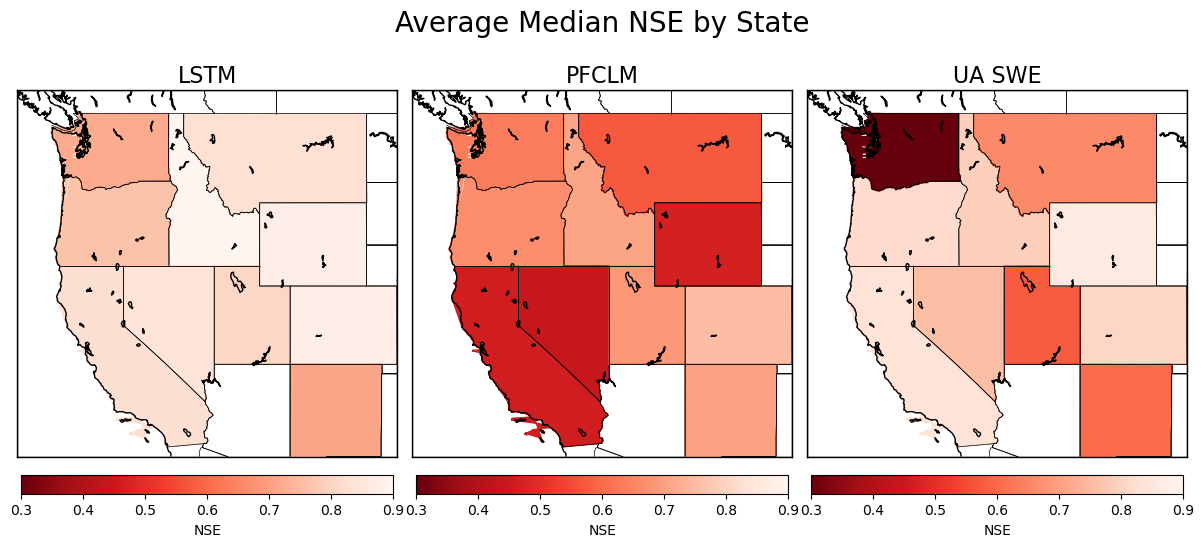

In [100]:
## COLOR MAP OF MODEL PERFORMANCE - PLOT ##
lstm_results['state'] = np.array(x.split(':')[1] for x in lstm_results['site_id'])
lstm_results_agg_state = lstm_results.drop(columns=['site_id','year','train']).groupby('state').median().reset_index()
clm_results['state'] = np.array(x.split(':')[1] for x in clm_results['site_id'])
clm_results_agg_state = clm_results.drop(columns=['site_id','year','train']).groupby('state').median().reset_index()
ua_results['state'] = np.array(x.split(':')[1] for x in ua_results['site_id'])
ua_results_agg_state = ua_results.drop(columns=['site_id','year','train']).groupby('state').median().reset_index()

# plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 10))
metric = 'nse'
aggregate_results = [lstm_results_agg_state, clm_results_agg_state, ua_results_agg_state]

for i in range(0, 3):
    values = aggregate_results[i]

    # create basemap
    m = Basemap(projection='merc', llcrnrlon=-127, llcrnrlat=32, urcrnrlon=-102, urcrnrlat=50, resolution='i', ax=axes[i])
    m.readshapefile('Data/us_state_shapefile/s_05mr24', name='STATE', drawbounds=True)

    # Loop through state_info to gather all polygons for each state
    state_polygons = defaultdict(list)
    for shape_dict, shape in zip(m.STATE_info, m.STATE):
       state_name = shape_dict['STATE']  # or the appropriate attribute for state name
       state_polygons[state_name].append(np.array(shape))  # Aggregate coordinates for the state

    # Create a color map based on accuracy
    norm = plt.Normalize(0.3, 0.9)
    if metric=='nse':
        cmap = plt.get_cmap('Reds_r')
    else:
        cmap = plt.get_cmap('Reds')

    # Shade states based on average accuracy
    patches = []
    for state_name, polygons in state_polygons.items():
        if state_name in values['state'].values:
            accuracy_value = values.loc[values['state'] == state_name, metric].values[0]
            color = cmap(norm(accuracy_value))
            
            #for polygon in polygons:
            merged_coords = np.vstack(polygons)  # Merge the list of arrays into one array
            patches.append(Polygon(merged_coords, closed=True, facecolor=color, edgecolor=color))
    
    axes[i].add_collection(PatchCollection(patches, match_original=True, zorder=2))
    m.drawmapboundary()
    m.drawcountries()
    m.drawcoastlines()
    m.drawstates()
    
    # individual plot things
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[i], orientation='horizontal', pad=0.02, shrink=0.98)
    if i==0:
        axes[i].set_title('LSTM', fontsize=16)
    if i==1:
        axes[i].set_title('PFCLM', fontsize=16)
    if i==2:
        axes[i].set_title('UA SWE', fontsize=16)
    cbar.set_label(metric.upper())

# plot things
fig.suptitle('Average Median NSE by State', fontsize=20, y=0.62)
plt.tight_layout() 

# unused code

In [ ]:
# ## COMBINE DATA - MEAN ##
# model_statistics = pd.DataFrame(columns=['run name','rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days'])
# # UA SWE
# model_statistics.loc[len(model_statistics)] = ['UA SWE', np.mean(total_statistics['rmse']), np.mean(total_statistics['normal rmse']),
#                                                np.mean(total_statistics['nse']), np.mean(total_statistics['r2']),
#                                                np.mean(total_statistics['spearman_rho']), np.mean((total_statistics['delta peak'])), 
#                                                np.mean((total_statistics['normal delta peak'])), np.mean(total_statistics['delta days'])]
# # PF CLM
# model_statistics.loc[len(model_statistics)] = ['PFCLM', np.mean(total_statistics_pf['rmse']), np.mean(total_statistics_pf['normal rmse']),
#                                                np.mean(total_statistics_pf['nse']), np.mean(total_statistics_pf['r2']),
#                                                np.mean(total_statistics_pf['spearman_rho']), np.mean((total_statistics_pf['delta peak'])), 
#                                                np.mean((total_statistics_pf['normal delta peak'])), np.mean(total_statistics_pf['delta days'])]
# # LSTM 
# model_statistics.loc[len(model_statistics)] = ['LSTM', np.mean(total_statistics_lstm['rmse']), np.mean(total_statistics_lstm['normal rmse']),
#                                                np.mean(total_statistics_lstm['nse']), np.mean(total_statistics_lstm['r2']),
#                                                np.mean(total_statistics_lstm['spearman_rho']), np.mean((total_statistics_lstm['delta peak'])), 
#                                                np.mean((total_statistics_lstm['normal delta peak'])), 
#                                                np.mean(total_statistics_lstm['delta days'])]
# model_statistics['normal delta days'] = model_statistics['delta days']/365

In [ ]:
## HEATMAP ##
# adjust data
model_statistics = model_statistics.set_index('run name')
model_statistics_plot = model_statistics.drop(columns=['r2','rmse','delta peak','delta days'])
model_statistics = model_statistics.drop(columns=['r2','normal rmse','normal delta peak','normal delta days'])

# adjust colors
model_statistics_plot['nse'] = 1-model_statistics_plot['nse']
model_statistics_plot['spearman_rho'] = 1-model_statistics_plot['spearman_rho']
model_statistics_plot = np.abs(model_statistics_plot)
model_statistics_plot = model_statistics_plot.transpose()
model_statistics = model_statistics.transpose()

# plot
ax = sns.heatmap(model_statistics_plot, annot=model_statistics, fmt=".2f", cmap='Reds', vmax=0.4, cbar=False,
                 yticklabels = ['RMSE','NSE','Spearman rho','Delta Peak SWE','Delta Days'], xticklabels=['UA SWE','PFCLM','LSTM'])
ax.set(title='Comparison with Other Models', xlabel='Model Name')

In [ ]:
# # AVERAGE OF MULITPLE LSTM MODELS 
# # ignore the names they're random
# # ['l5_162','l3_200','l5_200']
# # MAKE THIS THE MEAN OF 3 BEST RUNS
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# data_test = pd.read_csv('/home/mcburns/national_lstm/national_test_years.txt', sep=' ',header=None)
# data_test.columns = ['site_id',	'year',	'train']

# plt.figure(figsize=(32,24))

# #total_statistics_lstm = pd.DataFrame(columns=['rmse', 'normal rmse', 'nse', 'r2', 'spearman_rho', 'delta peak', 'normal delta peak', 'delta days'])

# lstm_p3_48 = torch.load('/home/mcburns/national_lstm/output/l5_162_lstm.pt', map_location = DEVICE)
# lstm_p1_24 = torch.load('/home/mcburns/national_lstm/output/l3_200_lstm.pt', map_location = DEVICE)
# lstm_l5_16 = torch.load('/home/mcburns/national_lstm/output/l5_200_lstm.pt', map_location = DEVICE)

# test_swe_p3_48 = torch.load('/home/mcburns/national_lstm/output/l5_162_test_swe.pt')
# test_non_swe_p3_48 = torch.load('/home/mcburns/national_lstm/output/l5_162_test_non_swe.pt')
# test_non_swe_p1_24 = torch.load('/home/mcburns/national_lstm/output/l3_200_test_non_swe.pt')
# test_non_swe_l5_16 = torch.load('/home/mcburns/national_lstm/output/l5_200_test_non_swe.pt')
# with open('/home/mcburns/national_lstm/output/l5_162_normalize.pkl', 'rb') as file:  
#     l_normalize = pickle.load(file)
# scaler_swe_p3_48 = l_normalize[0]
# with open('/home/mcburns/national_lstm/output/l3_200_normalize.pkl', 'rb') as file:  
#     l_normalize = pickle.load(file)
# scaler_swe_p1_24 = l_normalize[0]
# with open('/home/mcburns/national_lstm/output/l5_200_normalize.pkl', 'rb') as file:  
#     l_normalize = pickle.load(file)
# scaler_swe_l5_16 = l_normalize[0]

# # GET PARFLOW RESULTS FOR EACH SITE
# for i in range(0, len(data_test)):
#     site_id = data_test['site_id'][i]
#     year = data_test['year'][i]
#     start_date = str(year-1) + '-10-01'
#     end_date = str(year) + '-09-30'

#     test_swe_tensors_p3_48 = test_swe_p3_48[i]
    
#     test_non_swe_tensors_p3_48 = torch.reshape(test_non_swe_p3_48[i], (test_non_swe_p3_48[i].shape[0], 1, 
#                                                                        test_non_swe_p3_48[i].shape[1])).to(DEVICE)
#     swe_pred_p3_48 = lstm_p3_48(test_non_swe_tensors_p3_48)
#     swe_pred_p3_48 = scaler_swe_p3_48.inverse_transform(swe_pred_p3_48.cpu().detach().numpy().reshape(-1,1))
    
#     test_non_swe_tensors_p1_24 = torch.reshape(test_non_swe_p1_24[i], (test_non_swe_p1_24[i].shape[0], 1, 
#                                                                        test_non_swe_p1_24[i].shape[1])).to(DEVICE)
#     swe_pred_p1_24 = lstm_p1_24(test_non_swe_tensors_p1_24)
#     swe_pred_p1_24 = scaler_swe_p1_24.inverse_transform(swe_pred_p1_24.cpu().detach().numpy().reshape(-1,1))
    
#     test_non_swe_tensors_l5_16 = torch.reshape(test_non_swe_l5_16[i], (test_non_swe_l5_16[i].shape[0], 1, 
#                                                                        test_non_swe_l5_16[i].shape[1])).to(DEVICE)
#     swe_pred_l5_16 = lstm_l5_16(test_non_swe_tensors_l5_16)
#     swe_pred_l5_16 = scaler_swe_l5_16.inverse_transform(swe_pred_l5_16.cpu().detach().numpy().reshape(-1,1))
    
#     test_swe = scaler_swe_p3_48.inverse_transform(test_swe_tensors_p3_48.cpu().detach().numpy().reshape(-1,1))
    
#     swe_pred = np.mean([swe_pred_p3_48,swe_pred_p1_24,swe_pred_l5_16], axis=0)

#     # for regional/national model:
#     if (i < 36):
#         plt.subplot(6, 6, i+1)
#         # blue is actual, green is predicted
#         plt.plot(swe_pred, label='LSTM', c='red')
#         plt.plot(test_swe, label='SNOTEL', c='blue')
#         plt.title(site_id + ': '+ str(year))
#         plt.xlabel('days in WY')
#         plt.ylabel('SWE [mm]')
#         plt.ylim(bottom=-5)

# plt.tight_layout()